#### File Setup

In [1]:
#pip install pycountry-convert --quiet
#pip install seaborn  --quiet
#pip install scipy --quiet
#pip install researchpy --quiet
#pip install statsmodels --quiet

In [29]:
import pandas as pd 
import numpy as np
import re
import tabulate
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns 
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
from statsmodels.miscmodels.ordinal_model import OrderedModel
import mord 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


### Data Cleaning & Set-up

In [10]:
###csv_file = "/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/data/072823_results.csv"
csv_file = "/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/data/080823_results.csv"

###csv_file = "/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/data/080523_results.csv"

df = pd.read_csv(csv_file)
print(df.shape)

(351, 94)


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 94 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   StartDate                      351 non-null    object 
 1   EndDate                        351 non-null    object 
 2   Status                         351 non-null    object 
 3   Progress                       351 non-null    int64  
 4   Duration (in seconds)          351 non-null    int64  
 5   Finished                       351 non-null    bool   
 6   RecordedDate                   351 non-null    object 
 7   ResponseId                     351 non-null    object 
 8   DistributionChannel            351 non-null    object 
 9   UserLanguage                   351 non-null    object 
 10  Q_RecaptchaScore               324 non-null    float64
 11  Q1. Metadata_Browser           351 non-null    object 
 12  Q1. Metadata_Version           351 non-null    obj

#### Basic Data Cleaning 

In [11]:
##### Data cleaning to change column types

#drop anyone not sorted into condition 
df_clean = df.drop(df[df['Condition'].isna()].index)

#change data type to int 
df_clean['Condition'] =  df_clean['Condition'].astype('int64')

# create frame column gain or loss condition based on condition value 
df_clean['frame'] = df_clean['Condition'].apply(lambda x: 'gain' if x < 3 else 'loss')

#filter only where progress = 100 
df_clean = df_clean[df_clean['Progress']==100]
print(df_clean.shape)

(263, 95)


##### Survey Time / Completion

In [52]:
df_clean['Duration (in seconds)'].describe()

count       263.000000
mean       2280.391635
std       18053.102777
min          43.000000
25%         190.000000
50%         302.000000
75%         659.000000
max      241785.000000
Name: Duration (in seconds), dtype: float64

In [6]:
## visual completion times 
#sns.histplot( y='Duration (in seconds)', data =df_clean)
#plt.show()

In [12]:

##def remove_outliers(df, column_name):
    # Calculate Z-scores for the column
    #z_scores = stats.zscore(df[column_name])
    #threshold = 3 #3 standard deviations 
    # Filter the dataframe to keep only the data within the threshold
    ##df_clean = df[abs(z_scores) < threshold]

    #return df_clean
#apply function to remove outliers 
##column_name = 'Duration (in seconds)'
##df_clean = remove_outliers(df_clean, column_name) 


# quarterlie range
quartiles = df_clean['Duration (in seconds)'].quantile([0.25, 0.75])
iqr = quartiles[0.75] - quartiles[0.25]
lower_bound = quartiles[0.25] - 1.5 * iqr
upper_bound = quartiles[0.75] + 1.5 * iqr

#remove outlier
df_clean = df_clean[(df_clean['Duration (in seconds)'] >= lower_bound) & (df_clean['Duration (in seconds)'] <= upper_bound)]
df_clean.shape

(224, 95)

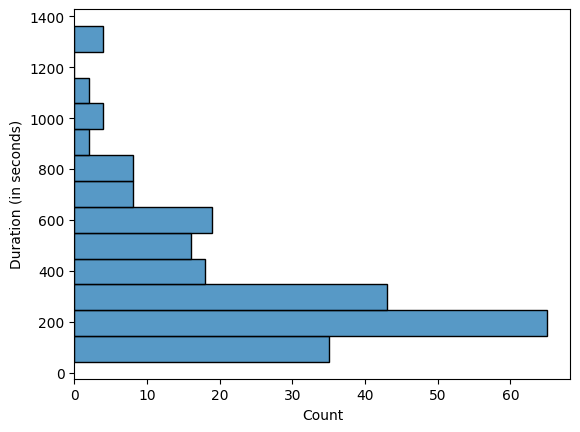

In [54]:
df_clean['Duration (in seconds)'].describe()
sns.histplot( y='Duration (in seconds)', data =df_clean)
plt.show()

In [55]:
#check for NAs
print(df_clean.isna().sum())

StartDate                0
EndDate                  0
Status                   0
Progress                 0
Duration (in seconds)    0
                        ..
Q10. Student             2
Q91                      5
Q63                      4
Condition                0
frame                    0
Length: 95, dtype: int64


##### Mapping Columns & Cleaning

In [13]:
import re 
#### Creating columns and grouping for various scenarios:
#filter to option columns only
columns = df_clean.columns 
option_columns = [col for col in columns if 'Option' in col]

# dictionary mapping
scenario_dict = {"GS1":"animals_gain", "GS2":"forest_gain", "GS3":"humans_gain", "LS1":"animals_loss", "LS2":"forest_loss", "LS3":"humans_loss"  }

#set columns based on scenario 
def scenario(row):
    for col in option_columns:
        if pd.notnull(row[col]):
            match = re.search(r'(GS\d+|LS\d+)', col)
            if match:
                return match.group()
    return None

# get scenario from dictionary 
def get_scenario(row):
    value = row['scenario']
    if value in scenario_dict:
        return scenario_dict[value]
    return None

# match scenario to dict
df_clean['scenario'] = df_clean[option_columns].apply(lambda row: scenario(row), axis=1)
df_clean['scenario_mapped'] = df_clean.apply(lambda row: get_scenario(row), axis=1)


In [14]:
##### Option Column Cleaning
# select option columns 
df_clean['option_selected'] = df_clean[option_columns].fillna(method='ffill', axis=1).iloc[:, -1]
##option_columns = ['Q12. GS1, Option','Q12. GS2, Option', 'Q12. GS3, Option.', 'Q12. LS1, Option', 'Q12. LS2, Option', 'Q12. LS3, Option']

# Rating column clean & creation 
rating_columns = ['Q13. GS1, Rating','Q13. GS2, Rating', 'Q13. GS3, Rating', 'Q13. LS1, Rating', 'Q13. LS2, Rating', 'Q13. LS3, Rating']
#create a new rating column containing the non-null values of the rating columns 
df_clean['rating'] = df_clean[rating_columns].fillna(method='ffill', axis=1).iloc[:, -1]
# drop where rating is na 
df_clean = df_clean[df_clean['rating'].notna()]
# get the number only from the column 
df_clean['rating_num'] = df_clean['rating'].apply(lambda x: x.split(":")[0])
# change to integer for calculation 
df_clean['rating_num'] = df_clean['rating_num'].astype('int')
#categorize rating categories
df_clean['rating_cat'] = df_clean['rating'].apply(lambda x: x.split(":")[1])
df_clean['rating_cat'] = df_clean['rating_cat'].apply(lambda x: x.strip())
rating_order =  [ 'Strong Preference for Proposal A', 'Preference for Proposal A', 'Slight Preference for Proposal A',  'No Preference for Proposal A or B',   'Slight Preference for Propsal B',  'Preference for Proposal B','Strong Preference for Proposal B']
df_clean['rating_cat'] = df_clean['rating_cat'].astype('category').cat.set_categories(rating_order, ordered=True)
df_clean['rating_cat'] = df_clean['rating'].apply(lambda x: x.split(":")[1])
df_clean['rating_cat'] = df_clean['rating_cat'].apply(lambda x: x.strip())
rating_order =  [ 'Strong Preference for Proposal A', 'Preference for Proposal A', 'Slight Preference for Proposal A',  'No Preference for Proposal A or B',   'Slight Preference for Propsal B',  'Preference for Proposal B','Strong Preference for Proposal B']
df_clean['rating_cat'] = df_clean['rating_cat'].astype('category').cat.set_categories(rating_order, ordered=True)

# Rationale column cleaning
rationale_columns = ['Q13. GS1, Rationale','Q14. GS2, Rationale', 'Q14. GS3, Rationle', 'Q14. LS1, Rationale', 'Q14. LS2, Rationale', 'Q14. LS3, Rationale']
# create a new rationale column containing the non-null values of the rating columns 
df_clean['rationale'] = df_clean[rationale_columns].fillna(method='ffill', axis=1).iloc[:, -1]

### Drop standalone choice, rationale, and rating columns
colu = rationale_columns + option_columns + rating_columns
df_clean = df_clean.drop(colu, axis= 'columns')
df_clean.shape

(223, 84)

In [15]:
### Cleaning and dropping time columns ###
columns = list(df_clean.columns)

###  First click columns
time_click1 = [col for col in columns if 'first click' in col.lower()]
#time first click for the scenario 
time_click1_scn = [string for string in time_click1 if string.startswith('Q10')]
#make as 1 column 
df_clean['scn_t_first_click'] = df_clean[time_click1_scn].fillna(method='ffill', axis=1).iloc[:, -1]

### Last click columns
time_click2 = [col for col in columns if 'last click' in col.lower()]
time_click2_scn = [string for string in time_click2 if string.startswith('Q10')]
df_clean['scn_t_last_click'] = df_clean[time_click2_scn].fillna(method='ffill', axis=1).iloc[:, -1]

### Time Submit Scenario columns
time_submit = [col for col in columns if 'submit' in col.lower()]
time_submit_scn = [string for string in time_submit if string.startswith('Q10')]
df_clean['scn_t_submit'] = df_clean[time_submit_scn].fillna(method='ffill', axis=1).iloc[:, -1]

#click_count1_scn = [string for string in click_count1 if 'dem' in string.lower()]

## drop Q10 time columns 
columns_drop = time_click2_scn + time_click1_scn + time_submit_scn
df_clean = df_clean.drop(columns_drop, axis = 'columns')

##Click count cleaning 
columns = list(df_clean.columns)
## Click Count for Scenario 
click_count1 = [col for col in columns if 'click count' in col.lower()]
#filer only scenario click coun t
click_count_scn = [string for string in click_count1 if string.startswith('Q10')]
#make as 1 column for all scenarios 
df_clean['scn_click_count'] = df_clean[click_count_scn].fillna(method='ffill', axis=1).iloc[:, -1]

## Click Count for Scenario 
click_count = [col for col in columns if 'click count' in col.lower()]
click_count1_dem = [string for string in click_count if 'dem' in string.lower()]
df_clean['dem_click_count'] = df_clean[click_count1_dem].fillna(method='ffill', axis=1).iloc[:, -1]

# drop scenario and dem click count columns 
columns_drop = click_count_scn + click_count1_dem
df_clean = df_clean.drop(columns_drop, axis = 'columns')

### drop metadata or misc columns from analysis 
metadata_or_misc = ['Q1. Metadata_Browser','Q1. Metadata_Version', 'Q1. Metadata_Operating System','Q1. Metadata_Resolution', 'UserLanguage', 'DistributionChannel', 'Status']
df_clean = df_clean.drop(metadata_or_misc, axis = 'columns')

In [16]:
scenario_times = ['scn_t_first_click',  'scn_t_last_click', 'scn_t_submit']
df_clean[scenario_times]
#create column for total time for scenario question: 
df_clean['scenario_time_to_choose'] = df_clean['scn_t_last_click'] - df_clean['scn_t_first_click']
df_clean['scenario_total_time'] = df_clean['scn_t_submit'] - df_clean['scn_t_first_click']
scenario_time = ['scenario_time_to_choose', 'scenario_total_time']
df_clean[scenario_time].describe()

,scenario_time_to_choose,scenario_total_time
count,223.000000,223.000000
mean,80.489260,93.106063
std,106.485346,107.692653
min,0.489000,1.678000
25%,15.375500,27.937000
50%,46.309000,62.502000
75%,107.093500,118.370500
max,776.420000,779.137000


In [17]:
df_clean.shape

(223, 58)

### Demographics

##### Cleaning 

In [18]:
#rename columns 
df_clean = df_clean.rename(columns={
    'Q5. Age': 'age',
    'Q6. Gender': 'gender',
    'Q6. Gender_4_TEXT': 'gender_text',
    'Q8. Ethnicity': 'ethnicity',
    'Q8. Ethnicity_6_TEXT': 'ethnicity_text',
    'Q9. Education': 'education',
    'Q10. Country': 'country',
    'Q10. Student': 'student',
    'Q91': 'ADP_familiar'
})

In [19]:
###coutry name clean 
import pycountry_convert as pc

#function to rename messy countries
def rename_countries(country):
    if pd.isnull(country):  # Check if the value is nan
        return country
    if country in ['United States of America', 'USA', 'US', 'us', 'usa', 'America', 'America   ', 'the United States', 'The United States',  'United States ', 'Amrican', 'United States', 'Florida', 'New York', 'MA', 'NZ', 'North Carolina', 'Newyork', 'denver', 'New York, USA','LA' , 'Mississippi', 'Texas'   ]:
        return 'USA'
    elif country in ['United Kingdom', 'United Kingdom ', 'UK', 'England', 'England ', 'Cambridge', 'London', 'uuk', 'U.K.', 'uk', 'Britain', 'Wales', 'Uk', 'West Norwood']:
        return 'UK'
    elif country in ['the Netherlands', 'The netherlands', 'Netherlands']:
        return 'Netherlands'
    elif country in ['China', '中国', 'Chinese ', '美国','加州']:
        return 'China'
    elif country in [ 'New Zealand']:
        return 'New Zealand'
    elif country in [ 'poland', 'Poland']:
        return 'Poland'
    elif country in ['Paris, France', 'France']:
        return 'France'
    elif country in ['Australia', 'Australia ']:
        return 'Australia'
    elif country in ['pakistan']:
        return 'Pakistan'
    elif country in ['united arab emirates', 'UAE']: 
        return 'United Arab Emirates'
    else:
        return country  # return the original name if no match is found

#update country column 
df_clean['country'] = df_clean['country'].apply(rename_countries)
#strip any remaining whitespaces
df_clean['country'] = df_clean['country'].apply(lambda x: x.strip() if isinstance(x, str) else x) #checks if string, then removes spaces 

# Map each country to the continent
def country_to_continent(country_name):
    try:
        if country_name == 'USA':
            country_alpha2 = "US"
        elif country_name == 'UK':
            country_alpha2 = "GB"
        else:
            country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return "Not Provided"

df_clean['continent'] = df_clean['country'].apply(country_to_continent)

## group continent variables for stable regression estimates  
def group_small_categories(continent):
    if continent in ["South America", "Oceania", "Not Provided"]:
        return "Other / Not Provided"
    else:
        return continent
    
cont_order = ['North America', 'Europe', 'Asia','Other / Not Provided' ]
df_clean['continent_grouped'] = df_clean['continent'].apply(group_small_categories)
df_clean['continent_grouped'] = pd.Categorical(df_clean['continent_grouped'], categories=cont_order, ordered=True)

In [20]:
## Clean Education, Education , and age
#- necessary for stable regression estimates 

##clean ethnicity data
df_clean.ethnicity = df_clean.ethnicity.replace('White or Caucasian,Asian', 'Other')

#education
df_clean.education = df_clean.education.replace("Some high school / secondary school or less" ,"Completed high school / secondary school" )

#age
df_clean.age = df_clean.age.replace("45 - 54 years old" ,"45+" )
df_clean.age = df_clean.age.replace("55 - 64 years old" ,"45+" )


In [21]:
###### Cat Code Variables #########

# ####Gender: clean gender column into numbers
#clean third cat as 'other'
df_clean['gender'] = df_clean.gender.apply(lambda x: "Female" if x == 'Female' else ("Male" if x == 'Male' else "Other"))
#0 if female, 1 if male, 2 if other 
df_clean['gender_num'] = df_clean.gender.apply(lambda x: 0 if x == 'Female' else (1 if x == 'Male' else 2))
df_clean.groupby(['gender','gender_num'])['ResponseId'].count()

####Student: clean student column into numbers
#0 if not a student, 1 if a student
df_clean['student_num']= df_clean.student.astype('category').cat.codes
df_clean.groupby(['student','student_num'])['ResponseId'].count()

####Education: clean education column into numbers
#education_num: 0 = Associates, 1 = Bachecholars, 2 = Completed High School, 3 = Grad School, 4 = Prefer Not to Say, 5 = Some high school 
df_clean['education_num']= df_clean.education.astype('category').cat.codes
df_clean.groupby(['education','education_num'])['ResponseId'].count()

#### Ethnicity: clean ethnicity column into numbers
#ethnicity: 0 = African American, 1 = Black/African/Caribbean, 2 = Prefer not to say, 3 = White or Caucasian
df_clean['ethnicity_num']= df_clean.ethnicity.astype('category').cat.codes
df_clean.groupby(['ethnicity','ethnicity_num'])['ResponseId'].count()

#### Continent: clean contintent column into numbers
#continent: 0 = Asia, 1 = Europe, 2 = North America, 3 = Oceania, 4 = South America, 5 = Unknown 
df_clean['continent_num']= df_clean.continent.astype('category').cat.codes
df_clean.groupby(['continent','continent_num'])['ResponseId'].count()  

#### ADP: lean ADP column into numbers
#ADP: 0 = I'm not sure, 1 = No, 2 = Yes 
df_clean['ADP_num']= df_clean.ADP_familiar.astype('category').cat.codes
df_clean.groupby(['ADP_familiar','ADP_num'])['ResponseId'].count()

#### Age: clean age column into numbers
#age: {'18 - 24 years old': 0, '25 - 34 years old': 1, '35 - 44 years old': 2, '45 - 54 years old': 3, '55 - 64 years old': 4}
age_order = ['18 - 24 years old', '25 - 34 years old', '35 - 44 years old', '45 - 54 years old', '55 - 64 years old']
age_mapping = {age: i for i, age in enumerate(age_order)}
df_clean['age_num'] = df_clean['age'].map(age_mapping) #maps dict 


#### Demographic Insights 

Defintions
- gender_num: 0 = female, 1 = male, 2 = other
- student_num: 0 = not a studnet, 1 = a student, -1 = NA
- education_num: 0 = Associates, 1 = Bachecholars, 2 = Completed High School, 3 = Grad School, 4 = Prefer Not to Say, 5 = Some high school 
- ethnicity: 0 = African American, 1 = Black/African/Caribbean, 2 = Prefer not to say, 3 = White or Caucasian
- continent: 0 = Asia, 1 = Europe, 2 = North America, 3 = Oceania, 4 = South America, 5 = Unknown 
- ADP: 0 = I'm not sure, 1 = No, 2 = Yes 
- age: {'18 - 24 years old': 0, '25 - 34 years old': 1, '35 - 44 years old': 2, '45 - 54 years old': 3, '55 - 64 years old': 4}

##### Participant Demographic Insights 

In [185]:
demographics = ['age',  'gender',  'gender_num', 'ethnicity',  'education',  'continent',  'ADP_familiar',  'student', 'frame']
demographics_num = [ 'age_num',   'gender_num',  'ethnicity_num',  'education_num',   'continent_num', 'ADP_num', 'student_num', 'frame']
df_demographics = df_clean[demographics]

def create_table_characteristics(df, column):
    # group by the characteristic column and frame and count the occurrences
    counts = df.groupby([column, 'frame']).size().unstack().fillna(0).astype(int)
    #add the Full sample column
    counts['Full sample'] = counts.sum(axis=1)
    percentages = (counts.divide(counts.sum(axis=1), axis=0) * 100).round().astype(int)
    columns = []
    for col in counts.columns:
        columns.append((col, 'n'))
        columns.append((col, '%'))
    final_df = pd.DataFrame()
    for col in counts.columns:
        final_df[(col, 'n')] = counts[col]
        final_df[(col, '%')] = percentages[col]

    final_df.columns = pd.MultiIndex.from_tuples(columns)
    return final_df

age_table = create_table_characteristics(df_clean, 'age')
gender_table = create_table_characteristics(df_clean, 'gender')
education_table = create_table_characteristics(df_clean, 'education')
ethnicity_table = create_table_characteristics(df_clean, 'ethnicity')
student_table = create_table_characteristics(df_clean, 'student')

##print(tabulate(gender_table, headers='keys', tablefmt='grid'))
##print(tabulate(education_table, headers='keys', tablefmt='grid'))
pd.crosstab(df_clean['age'],df_clean['frame'], margins = True )

##df_clean.age.count() #111   112  223
df_clean.education.unique()

array(['Associates or technical degree', "Bachelor's degree",
       'Completed high school / secondary school',
       'Graduate or professional degree (MA, MS, MBA, PHd, JD, MD, etc.)',
       nan], dtype=object)

In [179]:
#ethnicity
df_demographics.ethnicity.value_counts(normalize=True).to_frame()
df_demographics['gender'].value_counts(normalize=True).to_frame()
df_demographics['continent'].value_counts(normalize=True).to_frame()
df_demographics['student'].value_counts(normalize=True).to_frame()
df_demographics['ADP_familiar'].value_counts(normalize=True).to_frame()
df_demographics['education'].value_counts(normalize=True).to_frame()

loss = df_demographics[df_demographics['frame']  == 'loss']

ed = pd.crosstab(loss['education'], loss['frame'], normalize = 'columns').reset_index()


### NEP Scoring

In [22]:
columns = df_clean.columns
#nep columns only
nep_columns = [col for col in columns if col.startswith('Q. NEP')]

#function to clean likert score data 
def extract_score(likert): 
   match = re.search(r'\d', likert)
   if match: 
      return int(match.group(0))
   return 0
   
# apply function to nep columns 
for col in df_clean[nep_columns]: 
   df_clean[col] = df_clean[col].astype(str)
df_clean[nep_columns] = df_clean[nep_columns].applymap(extract_score)

# function to sum score
def sum_score(row):
   if pd.notna(row).all():  #all nep questions answered
      return row.sum()
   else:
      return "N/A"

#new column that sums score
df_clean['NEP_Score'] = df_clean[nep_columns].apply(lambda row: sum_score(row), axis=1)


In [26]:
#some insights on each NEP question
stats_by_q = df_clean[nep_columns].describe().T
stats_by_q

,count,mean,std,min,25%,50%,75%,max
Q. NEP_1,206.0,2.349515,1.061143,0.0,2.0,2.0,3.0,5.0
Q. NEP_2,206.0,2.067961,0.975426,0.0,1.0,2.0,3.0,5.0
Q. NEP_3,206.0,1.970874,1.054202,0.0,1.0,2.0,3.0,5.0
Q. NEP_4,206.0,1.966019,1.065563,0.0,1.0,2.0,3.0,5.0
Q. NEP_5,206.0,1.864078,0.998033,0.0,1.0,2.0,2.0,5.0
Q. NEP_6,206.0,1.985437,1.028748,0.0,1.0,2.0,3.0,5.0
Q. NEP_7,206.0,2.135922,1.050422,0.0,1.0,2.0,3.0,5.0
Q. NEP_8,206.0,2.048544,1.094364,0.0,1.0,2.0,3.0,5.0


### Exploratory

In [20]:
###set-yp analysis 

main_analysis_columns = ['ResponseId', 'frame', 'scenario_mapped', 'option_selected', 'rating_num', 'rationale', 'age_num',  'gender_num',  'ethnicity_num', 'education_num',  'student_num' , 'continent_num', 'ADP_num', 'student_num','NEP_Score']
analysis_columns = ['ResponseId', 'frame', 'scenario_mapped', 'option_selected', 'rating', 'rating_num', 'rationale',
'age', 'age_num', 'gender',  'gender_num', 'ethnicity', 'ethnicity_num', 'education', 'education_num', 'continent_grouped',  'continent_num', 
'ADP_num','ADP_familiar',  'student', 'student_num', 'NEP_Score']

#set up dataframe 
main_analysis = df_clean[analysis_columns]

#remove one off na option_selection
main_analysis = main_analysis[~main_analysis['scenario_mapped'].isna()] 

#gain & loss conditions 
gain_condition = main_analysis[main_analysis['frame']=='gain']
loss_condition = main_analysis[main_analysis['frame']=='loss']

#add scenario cleaned column with just animals, humans, or forest 
main_analysis['scenario_clean'] = main_analysis['scenario_mapped'].apply(lambda x: x.split("_")[0] ) 

In [21]:
##ratin num (8/8 version )
print(pd.crosstab(main_analysis['frame'], main_analysis['option_selected'], values = main_analysis['rating_num'], aggfunc = 'mean' ))
rap_gain3 = main_analysis[main_analysis['frame'] == 'gain']
rap_loss3 = main_analysis[main_analysis['frame'] == 'loss']
gain_avg3 = rap_gain3.rating_num.mean()
loss_avg3 = rap_loss3.rating_num.mean()
print("gain avg rating:", gain_avg3)
print("loss avg rating:", loss_avg3)
print('delta:', loss_avg3 - gain_avg3)

option_selected  Proposal A  Proposal B
frame                                  
gain               2.607143    5.307692
loss               2.907895    5.388889
gain avg rating: 3.2454545454545456
loss avg rating: 3.705357142857143
delta: 0.4599025974025972


In [22]:
print(pd.crosstab(main_analysis['frame'], main_analysis['option_selected'], values = main_analysis['rating_num'], aggfunc = 'mean' ))


option_selected  Proposal A  Proposal B
frame                                  
gain               2.607143    5.307692
loss               2.907895    5.388889


In [88]:
##ratin num (8/8 version )
print(pd.crosstab(main_analysis['frame'], main_analysis['option_selected'], values = main_analysis['rating_num'], aggfunc = 'mean' ))
rap_gain3 = main_analysis[main_analysis['frame'] == 'gain']
rap_loss3 = main_analysis[main_analysis['frame'] == 'loss']
gain_avg3 = rap_gain3.rating_num.mean()
loss_avg3 = rap_loss3.rating_num.mean()
print("gain avg rating:", gain_avg3)
print("loss avg rating:", loss_avg3)
print('delta:', loss_avg3 - gain_avg3)

option_selected  Proposal A  Proposal B
frame                                  
gain               2.623377    5.260870
loss               2.902778    5.393939
gain avg rating: 3.23
loss avg rating: 3.6857142857142855
delta: 0.4557142857142855


#### Rationale & Rating Exploration

Creating dataframes for additional analysis 

In [23]:
##where rationale is null 
df_rationale_null = main_analysis[main_analysis['rationale'].isna()]

##where rationale is not null 
df_rationale_not_null = main_analysis[~main_analysis['rationale'].isna()]

##look where rating is a mismatch 
rating_mismatch = main_analysis[((main_analysis['option_selected'] == 'Proposal A') & (main_analysis['rating_num'] > 4)) | (main_analysis['option_selected'] == 'Proposal B') & (main_analysis['rating_num'] < 4) ]

##look where rating is appr. 
rating_appr = main_analysis[((main_analysis['option_selected']=='Proposal A') & (main_analysis['rating_num']<= 4 )) | ((main_analysis['option_selected']=='Proposal B') & (main_analysis['rating_num'] >= 4 ))]

#gain & loss conditions -- rating_appr 
gain_condition_rating = rating_appr[rating_appr['frame']=='gain']
loss_condition_rating = rating_appr[rating_appr['frame']=='loss']

##look where rating is appr. & rationale is filled in 
rating_appr_rat = main_analysis[(main_analysis['option_selected']=='Proposal A') & (main_analysis['rating_num']<= 4 ) & (~main_analysis['rationale'].isna()) | (main_analysis['option_selected']=='Proposal B') & (main_analysis['rating_num'] >= 4) & (~main_analysis['rationale'].isna())]

#gain & loss conditions -- rating_appr_rat 
gain_condition_rating_rat = rating_appr_rat[rating_appr_rat['frame']=='gain']
loss_condition_rating_rat = rating_appr_rat[rating_appr_rat['frame']=='loss']

##where demographics (country) is not null 
df_country_not_null = main_analysis[main_analysis['continent_num'] != 5]
df_country_notna_ratingappr  =  rating_appr[~rating_appr['continent_num'] == 5 ]

#where rating is appr and no ADP
rating_appr_noADP = rating_appr[rating_appr['ADP_num'] != 2]

#where rating is appr and no ADP
rating_appr_rat_noADP = rating_appr_rat[rating_appr_rat['ADP_num'] != 2]


##outputs 
rating_mismatch_cross = pd.crosstab(rating_mismatch['frame'], rating_mismatch['option_selected'], values = rating_mismatch['rating_num'], aggfunc= 'mean' )
print("rating_mismatch_cross")
print(rating_mismatch_cross)

rating_appr_ct = pd.crosstab(rating_appr['frame'], rating_appr['option_selected'], values = rating_appr['rating_num'], aggfunc= 'mean' )
print("\nrating_appr_ct")
print(rating_appr_ct)

rating_appr_rat_ct = pd.crosstab(rating_appr_rat['frame'], rating_appr_rat['option_selected'], values = rating_appr_rat['rating_num'], aggfunc= 'mean' )
print(rating_appr_rat_ct)

main_analysis_ct = pd.crosstab(main_analysis['frame'], main_analysis['option_selected'], values = main_analysis['rating_num'], aggfunc= 'mean' )
print("\nmain_analysis ct")
print(main_analysis_ct)

rating_mismatch_cross
option_selected  Proposal A  Proposal B
frame                                  
gain               6.000000         2.0
loss               5.333333         3.0

rating_appr_ct
option_selected  Proposal A  Proposal B
frame                                  
gain               2.392405    5.583333
loss               2.453125    5.457143
option_selected  Proposal A  Proposal B
frame                                  
gain               2.362319    5.650000
loss               2.372093    5.457143

main_analysis ct
option_selected  Proposal A  Proposal B
frame                                  
gain               2.607143    5.307692
loss               2.907895    5.388889


In [130]:
##first look at breakdown 

#% of Participants Selecting Each Option 
frame_cross_pct = pd.crosstab(main_analysis['option_selected'], main_analysis['frame'], normalize='columns')
frame_cross_num = pd.crosstab(main_analysis['option_selected'], main_analysis['frame'])
print("Breakdown of Choice Selection (Main Analysis)")
print(f"""Sample Size: {main_analysis.shape[0]}""")
print(f"""Gain Sample Size: {main_analysis[main_analysis['frame'] == 'gain'].shape[0]}""")
print(f"""Loss Sample Size: {main_analysis[main_analysis['frame'] == 'loss'].shape[0]}""")
print(f"""\n\n{frame_cross_pct}""")

frame_cross_pct_rating = pd.crosstab(rating_appr['option_selected'], rating_appr['frame'], normalize='columns')
print("\n\nBreakdown of Choice Selection (Rating Appr)")
print(f"""{frame_cross_pct_rating}""")

Breakdown of Choice Selection (Main Analysis)
Sample Size: 222
Gain Sample Size: 110
Loss Sample Size: 112


frame                gain      loss
option_selected                    
Proposal A       0.763636  0.678571
Proposal B       0.236364  0.321429


Breakdown of Choice Selection (Rating Appr)
frame               gain      loss
option_selected                   
Proposal A       0.76699  0.646465
Proposal B       0.23301  0.353535


In [131]:
##first look at breakdown (8/8)

#% of Participants Selecting Each Option 
frame_cross_pct = pd.crosstab(main_analysis['option_selected'], main_analysis['frame'], normalize='columns')
frame_cross_num = pd.crosstab(main_analysis['option_selected'], main_analysis['frame'])
print("Breakdown of Choice Selection (Main Analysis)")
print(f"""Sample Size: {main_analysis.shape[0]}""")
print(f"""Gain Sample Size: {main_analysis[main_analysis['frame'] == 'gain'].shape[0]}""")
print(f"""Loss Sample Size: {main_analysis[main_analysis['frame'] == 'loss'].shape[0]}""")
print(f"""\n\n{frame_cross_pct}""")

frame_cross_pct_rating = pd.crosstab(rating_appr['option_selected'], rating_appr['frame'], normalize='columns')
print("\n\nBreakdown of Choice Selection (Rating Appr)")
print(f"""{frame_cross_pct_rating}""")

Breakdown of Choice Selection (Main Analysis)
Sample Size: 222
Gain Sample Size: 110
Loss Sample Size: 112


frame                gain      loss
option_selected                    
Proposal A       0.763636  0.678571
Proposal B       0.236364  0.321429


Breakdown of Choice Selection (Rating Appr)
frame               gain      loss
option_selected                   
Proposal A       0.76699  0.646465
Proposal B       0.23301  0.353535


In [133]:
###Compare rating data by segmentation 

##look where country is na 
print(pd.crosstab(df_country_not_null['frame'], df_country_not_null['option_selected'], values = df_country_not_null['rating_num'], aggfunc = 'mean' ))
rap_gain1 = df_country_not_null[df_country_not_null['frame'] == 'gain']
rap_loss1 = df_country_not_null[df_country_not_null['frame'] == 'loss']
gain_avg1 = rap_gain1.rating_num.mean()
loss_avg1 = rap_loss1.rating_num.mean()
print("gain avg rating:", gain_avg1)
print("loss avg rating:", loss_avg1)
print('delta:', loss_avg1 - gain_avg1)
print('/////')

##look across df_clean
print(pd.crosstab(df_clean['frame'], df_clean['option_selected'], values = df_clean['rating_num'], aggfunc = 'mean' ))
rap_gain3 = df_clean[df_clean['frame'] == 'gain']
rap_loss3 = df_clean[df_clean['frame'] == 'loss']
gain_avg3 = rap_gain3.rating_num.mean()
loss_avg3 = rap_loss3.rating_num.mean()
print("gain avg rating:", gain_avg3)
print("loss avg rating:", loss_avg3)
print('delta:', loss_avg3 - gain_avg3)

##looks across rating_appr
rap_gain = rating_appr[rating_appr['frame'] == 'gain']
rap_loss = rating_appr[rating_appr['frame'] == 'loss']
gain_avg = rap_gain.rating_num.mean()
loss_avg = rap_loss.rating_num.mean()
print("gain avg rating:", gain_avg)
print("loss avg rating:", loss_avg)
print('delta:', loss_avg - gain_avg)


##looks across rating_appr_rationale filled in 
rap_gain4 = rating_appr_rat[rating_appr_rat['frame'] == 'gain']
rap_loss4 = rating_appr_rat[rating_appr_rat['frame'] == 'loss']
gain_avg4 = rap_gain4.rating_num.mean()
loss_avg4 = rap_loss4.rating_num.mean()
print("gain avg rating:", gain_avg4)
print("loss avg rating:", loss_avg4)
print('delta:', loss_avg4 - gain_avg4)


##looks across main analysis 
main_gain = main_analysis[main_analysis['frame'] == 'gain']
main_loss = main_analysis[main_analysis['frame'] == 'loss']
gain_avg = main_gain.rating_num.mean()
loss_avg = main_loss.rating_num.mean()
print("gain avg rating:", main_gain.rating_num.mean())
print("loss avg rating:", main_loss.rating_num.mean())
print('delta:', loss_avg - gain_avg)




option_selected  Proposal A  Proposal B
frame                                  
gain               2.621951    5.307692
loss               2.907895    5.400000
gain avg rating: 3.2685185185185186
loss avg rating: 3.6936936936936937
delta: 0.4251751751751751
/////
option_selected  Proposal A  Proposal B
frame                                  
gain               2.607143    5.307692
loss               2.907895    5.388889
gain avg rating: 3.234234234234234
loss avg rating: 3.705357142857143
delta: 0.47112290862290873
gain avg rating: 3.1359223300970873
loss avg rating: 3.515151515151515
delta: 0.3792291850544278
gain avg rating: 3.101123595505618
loss avg rating: 3.7564102564102564
delta: 0.6552866609046384
gain avg rating: 3.2454545454545456
loss avg rating: 3.705357142857143
delta: 0.4599025974025972


In [368]:
##Rating Appr Only 
##looks across rating_appr
rap_gain = rating_appr[rating_appr['frame'] == 'gain']
rap_loss = rating_appr[rating_appr['frame'] == 'loss']
gain_avg = rap_gain.rating_num.mean()
loss_avg = rap_loss.rating_num.mean()
print("gain avg rating:", gain_avg)
print("loss avg rating:", loss_avg)
print('delta:', loss_avg - gain_avg)


gain avg rating: 3.1359223300970873
loss avg rating: 3.515151515151515
delta: 0.3792291850544278


In [138]:
##look at average rating by frame and option selected 

##Main Analysis 
print('nmain analysis:')
print(pd.crosstab(main_analysis['frame'],main_analysis['option_selected'], values = main_analysis['rating_num'] , aggfunc= 'mean'))

##Rating Appr 
print('\nrating appr:')
print(pd.crosstab(rating_appr['frame'],rating_appr['option_selected'], values = rating_appr['rating_num'] , aggfunc= 'mean'))


##Rating Appr Rat
print('\nrating appr rat:')
print(pd.crosstab(rating_appr_rat['frame'],rating_appr_rat['option_selected'], values = rating_appr_rat['rating_num'] , aggfunc= 'mean'))


nmain analysis:
option_selected  Proposal A  Proposal B
frame                                  
gain               2.607143    5.307692
loss               2.907895    5.388889

rating appr:
option_selected  Proposal A  Proposal B
frame                                  
gain               2.392405    5.583333
loss               2.453125    5.457143

rating appr rat:
option_selected  Proposal A  Proposal B
frame                                  
gain               2.362319    5.650000
loss               2.372093    5.457143


frame,gain,loss,All
scenario_clean,,,
forest,35,28,63
animals,34,37,71
humans,34,34,68
All,103,99,202


In [25]:
####TIME CHECK for RATIONALE 
pd.crosstab(df_rationale_null['option_selected'], df_rationale_null['frame'])

time = ['scn_t_first_click', 'scn_t_last_click', 'scn_t_submit',
       'scn_click_count', 'dem_click_count', 'scenario_time_to_choose',
       'scenario_total_time']

##time check for rationale not null 
time_rationale = df_rationale_not_null[time]
time_Nrationale = df_rationale_null[time]
time_rationale['Source'] = 'df_rationale_null'
time_Nrationale['Source'] = 'df_rationale_not_null'
concatenated_df = pd.concat([time_rationale, time_Nrationale], axis=0).reset_index(drop=True)

KeyError: "None of [Index(['scn_t_first_click', 'scn_t_last_click', 'scn_t_submit',\n       'scn_click_count', 'dem_click_count', 'scenario_time_to_choose',\n       'scenario_total_time'],\n      dtype='object')] are in the [columns]"

##### Duplicate Participant Look 

In [132]:
####Duplicate CHECK

###Drop where the rationale and all demographic factors are == 
df_rationale_non_null = main_analysis[main_analysis['rationale'].notna()]
df_rationale_null = main_analysis[main_analysis['rationale'].isna()]
df_rationale_non_null = df_rationale_non_null.drop_duplicates(subset=['rating_num', 'option_selected', 'rationale',  'gender_num', 'ethnicity_num','age_num' , 'education_num', 'NEP_Score'], keep='first')
df_nodup = pd.concat([df_rationale_non_null, df_rationale_null])
df_nodup_rap = df_nodup[((df_nodup['option_selected'] == 'Proposal A') & (df_nodup['rating_num'] <= 4)) | (df_nodup['option_selected'] == 'Proposal B') & (df_nodup['rating_num'] >= 4) ]

rap_gain = df_nodup_rap[df_nodup_rap['frame'] == 'gain']
rap_loss = df_nodup_rap[df_nodup_rap['frame'] == 'loss']
gain_avg = rap_gain.rating_num.mean()
loss_avg = rap_loss.rating_num.mean()
print("gain avg rating:", gain_avg)
print("loss avg rating:", loss_avg)
print('delta:', loss_avg - gain_avg)

gain avg rating: 3.1386138613861387
loss avg rating: 3.5306122448979593
delta: 0.3919983835118206


In [ ]:
####Cleaning for Rating and Duplicate Participants 
##new main analysis which removes the rating mismatch participants 
rating_mismatch = main_analysis[((main_analysis['option_selected'] == 'Proposal A') & (main_analysis['rating_num'] > 4)) | (main_analysis['option_selected'] == 'Proposal B') & (main_analysis['rating_num'] < 4) ]
main_analysis = main_analysis[((main_analysis['option_selected']=='Proposal A') & (main_analysis['rating_num']<= 4 )) | ((main_analysis['option_selected']=='Proposal B') & (main_analysis['rating_num'] >= 4 ))]
print("Participants removed with mismatch rating & choice selection:", rating_mismatch.shape[0])

###Drop where the rationale and all demographic factors are == 
df_rationale_non_null = main_analysis[main_analysis['rationale'].notna()]
df_rationale_null = main_analysis[main_analysis['rationale'].isna()]
df_rationale_non_null = df_rationale_non_null.drop_duplicates(subset=['rating_num', 'option_selected', 'rationale',  'gender_num', 'ethnicity_num','age_num' , 'education_num', 'NEP_Score'], keep='first')
df_nodup = pd.concat([df_rationale_non_null, df_rationale_null])
df_nodup_rap = df_nodup[((df_nodup['option_selected'] == 'Proposal A') & (df_nodup['rating_num'] <= 4)) | (df_nodup['option_selected'] == 'Proposal B') & (df_nodup['rating_num'] >= 4) ]

print("# of Participant Not ADP Familar:", ADP_notyes.shape[0])

#### Regression Explore

##### Set-up variables 

In [378]:
### Set-up variables 

#set gain as = 1
main_analysis['frame_gain'] = (main_analysis['frame'] == 'gain').astype(int)
rating_appr['frame_gain'] = (rating_appr['frame'] == 'gain').astype(int)
rating_appr_rat['frame_gain'] = (rating_appr_rat['frame'] == 'gain').astype(int)
rating_appr_noADP['frame_gain'] = (rating_appr_noADP['frame'] == 'gain').astype(int)
rating_appr_rat_noADP['frame_gain'] = (rating_appr_rat_noADP['frame'] == 'gain').astype(int)


####Set-up variables
import statsmodels.formula.api as smf
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

###### Note, main_analysis is where the rating matches the choice selection 
main_analysis['option_selected_B'] = le.fit_transform(main_analysis['option_selected']) ##0 = Prop A, 1 = Prop B
main_analysis['option_selected_A'] = 1 - main_analysis['option_selected_B']  ## Reversing the encoding

rating_appr['option_selected_B'] = le.fit_transform(rating_appr['option_selected']) ##0 = Prop A, 1 = Prop B
rating_appr['option_selected_A'] = 1 - rating_appr['option_selected_B']  ## Reversing the encoding

rating_appr_rat['option_selected_B'] = le.fit_transform(rating_appr_rat['option_selected']) ##0 = Prop A, 1 = Prop B
rating_appr_rat['option_selected_A'] = 1 - rating_appr_rat['option_selected_B']  ## Reversing the encoding

rating_appr_noADP['option_selected_B'] = le.fit_transform(rating_appr_noADP['option_selected']) ##0 = Prop A, 1 = Prop B
rating_appr_noADP['option_selected_A'] = 1 - rating_appr_noADP['option_selected_B']  ## Reversing the encoding

rating_appr_rat_noADP['option_selected_B'] = le.fit_transform(rating_appr_rat_noADP['option_selected']) ##0 = Prop A, 1 = Prop B
rating_appr_rat_noADP['option_selected_A'] = 1 - rating_appr_rat_noADP['option_selected_B']  ## Reversing the encoding

#df_nodup_rap['option_selected_cat'] = le.fit_transform(df_nodup_rap['option_selected']) ##0 = Prop A, 1 = Prop B
#df_nodup_rap['option_selected_rev'] = 1 - df_nodup_rap['option_selected_cat']  ## Reversing the encoding

#ADP_notyes['option_selected_cat'] = le.fit_transform(ADP_notyes['option_selected']) ##0 = Prop A, 1 = Prop B
#ADP_notyes['option_selected_rev'] = 1 - ADP_notyes['option_selected_cat']  ## Reversing the encoding


### ADP Variables 
adp_no = ['Yes', 'No']
adp_yes = ['No', 'Yes']

rating_appr['ADP_familiar'] = rating_appr['ADP_familiar'].replace("I'm not sure", "No")
rating_appr['ADP_No'] = pd.Categorical(rating_appr['ADP_familiar'], categories=adp_no, ordered=True)
rating_appr['ADP_Yes'] = pd.Categorical(rating_appr['ADP_familiar'], categories=adp_yes, ordered=True)

rating_appr_rat['ADP_familiar'] = rating_appr_rat['ADP_familiar'].replace("I'm not sure", "No")
rating_appr_rat['ADP_No'] = pd.Categorical(rating_appr_rat['ADP_familiar'], categories=adp_no, ordered=True)
rating_appr_rat['ADP_Yes'] = pd.Categorical(rating_appr_rat['ADP_familiar'], categories=adp_yes, ordered=True)

rating_appr_rat_noADP = rating_appr_rat[rating_appr_rat['ADP_num'] != 2]
rating_appr_noADP = rating_appr[rating_appr['ADP_num'] != 2]


##### For Ordinal 
#####Ordinal Regressions
from statsmodels.miscmodels.ordinal_model import OrderedModel

import mord 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
main_analysis['frame_cat'] = le.fit_transform(main_analysis['frame']) ##0 = gain; 1 = loss
main_analysis['frame_rev'] = 1 - main_analysis['frame_cat'] ##1 = gain; 0 = loss
main_analysis['scenario_clean_cat'] = le.fit_transform(main_analysis['scenario_clean'])
main_analysis['option_selected_B'] = le.fit_transform(main_analysis['option_selected']) ##0 = Prop A, 1 = Prop B
main_analysis['option_selected_A'] = 1 - main_analysis['option_selected_B']  ## Reversing the encoding

rating_appr['frame_cat'] = le.fit_transform(rating_appr['frame']) 
rating_appr['frame_rev'] = 1 - rating_appr['frame_cat']
rating_appr['option_selected_B'] = le.fit_transform(rating_appr['option_selected']) ##0 = Prop A, 1 = Prop B
rating_appr['option_selected_A'] = 1 - rating_appr['option_selected_B']  ## Reversing the encoding

#order and dummy scenario
rating_appr['scenario_clean'] = rating_appr['scenario_clean'].astype(pd.CategoricalDtype(categories=['forest', 'animals', 'humans'], ordered=True))
rating_appr['scenario_clean2'] = rating_appr['scenario_clean'].astype(pd.CategoricalDtype(categories=['animals', 'humans', 'forest'], ordered=True))
rating_appr['scenario_clean3'] = rating_appr['scenario_clean'].astype(pd.CategoricalDtype(categories=['humans', 'forest', 'animals'], ordered=True))


rating_appr['scenario_for'] = rating_appr['scenario_clean'].cat.codes
rating_appr['scenario_an'] = rating_appr['scenario_clean2'].cat.codes
rating_appr['scenario_hum'] = rating_appr['scenario_clean3'].cat.codes

#df_nodup_rap['frame_cat'] = le.fit_transform(df_nodup_rap['frame']) 
#df_nodup_rap['frame_rev'] =  1 - df_nodup_rap['frame_cat']
#df_nodup_rap['scenario_clean_cat'] = le.fit_transform(df_nodup_rap['scenario_clean'])


rating_appr_rat['frame_cat'] = le.fit_transform(rating_appr_rat['frame']) 
rating_appr_rat['frame_rev'] = 1 - rating_appr_rat['frame_cat']

rating_appr_rat['scenario_clean'] = rating_appr_rat['scenario_clean'].astype(pd.CategoricalDtype(categories=['forest', 'animals', 'humans'], ordered=True))
rating_appr_rat['scenario_for'] = rating_appr_rat['scenario_clean'].cat.codes

rating_appr_rat['option_selected_B'] = le.fit_transform(rating_appr_rat['option_selected']) ##0 = Prop A, 1 = Prop B
rating_appr_rat['option_selected_A'] = 1 - rating_appr_rat['option_selected_B']  ## Reversing the encoding

rating_appr_noADP['frame_cat'] = le.fit_transform(rating_appr_noADP['frame']) 
rating_appr_noADP['frame_rev'] = 1 - rating_appr_noADP['frame_cat']
rating_appr_noADP['scenario_clean_cat'] = le.fit_transform(rating_appr_noADP['scenario_clean'])
rating_appr_noADP['option_selected_B'] = le.fit_transform(rating_appr_noADP['option_selected']) ##0 = Prop A, 1 = Prop B
rating_appr_noADP['option_selected_A'] = 1 - rating_appr_noADP['option_selected_B']  ## Reversing the encoding


main_analysis['reversed_rating_num'] = 8 - main_analysis['rating_num']
rating_appr['reversed_rating_num'] = 8 - rating_appr['rating_num']
rating_appr_rat['reversed_rating_num'] = 8 - rating_appr_rat['rating_num']
rating_appr_noADP['reversed_rating_num'] = 8 - rating_appr_noADP['rating_num']


/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_65637/1330095610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_appr_rat['frame_gain'] = (rating_appr_rat['frame'] == 'gain').astype(int)
/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_65637/1330095610.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_appr_noADP['frame_gain'] = (rating_appr_noADP['frame'] == 'gain').astype(int)
/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_65637/1330095610.py:8: SettingW

In [371]:
#function for signficance 
def sig_effect(pvalue):
    if pvalue <= .01:
        return f"""significant at 1% level"""
    elif pvalue <= .05:
        return f"""significant at 5% level"""
    elif pvalue <= .1:
        return f"""significant at 10% level"""
    else:
        return "not significant"


##### Ordinal

In [266]:
####### Simple (no controls) Ordinal Regressions #####
##### Version 8/8 #####
##frame_rev: 1 = gain, 0 = loss
##frame_cat: 0 = gain, 1 = loss

##Rating Appr 
ord_logit_ratapp = OrderedModel.from_formula("rating_num ~ 0 + frame_gain ",rating_appr, distr='logit').fit(method='bfgs')
print("\nrating_appr")
print("frame coeff:", ord_logit_ratapp.params[0]) #frame coeff: -0.4026162882171143
print("frame p-vale:", ord_logit_ratapp.pvalues[0]) #frame p-vale: 0.10824411307025375
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp.pvalues[0])) #not significant
print(ord_logit_ratapp.summary())

##rating_appr_rat 
ord_logit_ratapp_rat = OrderedModel.from_formula("rating_num ~ 0 + frame_gain ",rating_appr_rat, distr='logit').fit(method='bfgs')
print("\nrating_appr_rat")
print("frame coeff:", ord_logit_ratapp_rat.params[0]) #frame coeff: -0.6553318352976806
print("frame p-vale:", ord_logit_ratapp_rat.pvalues[0]) #frame p-vale: 0.01854378741043065
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rat.pvalues[0])) ##significant at 5% level
print(ord_logit_ratapp_rat.summary())

############################## --- REVERSING Rating SCALE --- ##############################
##frame_rev or frame_gain: 1 = gain, 0 = loss

##Rating Appr 
ord_logit_ratapp_rev = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_gain ",rating_appr, distr='logit').fit(method='bfgs')
print("\nrating_appr, with reversed rating num")
print("frame coeff:", ord_logit_ratapp_rev.params[0]) #frame coeff:  0.40267782416887127
print("frame p-vale:", ord_logit_ratapp_rev.pvalues[0]) #frame p-vale: 0.1081917719418552
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rev.pvalues[0])) #not significant
print(ord_logit_ratapp_rev.summary())

##rating_appr_rat 
ord_logit_ratapp_rat_rev = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_gain ",rating_appr_rat, distr='logit').fit(method='bfgs')
print("\nrating_appr_rat, with reversed rating num")
print("frame coeff:", ord_logit_ratapp_rat_rev.params[0]) #frame coeff: 0.6553318352976806
print("frame p-vale:", ord_logit_ratapp_rat_rev.pvalues[0]) #frame p-vale: 0.01854378741043065
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rat_rev.pvalues[0])) ##significant at 5% level
print(ord_logit_ratapp_rat_rev.summary())

Optimization terminated successfully.
         Current function value: 1.769040
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20

rating_appr
frame coeff: -0.4026162882171143
frame p-vale: 0.10824411307025375

signficicant effect? -->  not significant
                             OrderedModel Results                             
Dep. Variable:             rating_num   Log-Likelihood:                -357.35
Model:                   OrderedModel   AIC:                             728.7
Method:            Maximum Likelihood   BIC:                             751.8
Date:                Sat, 12 Aug 2023                                         
Time:                        13:53:33                                         
No. Observations:                 202                                         
Df Residuals:                     195                                         
Df Model:                           1                                    

In [281]:
###table for Simple Comparison 
summary_stats_ord_v1 = [get_summary_stats(ord_logit_ratapp_rev), 
                 get_summary_stats(ord_logit_ratapp_rat_rev)]
summary_ord_df1 = pd.DataFrame(summary_stats_ord_v1)
summary_ord_df1.T

table1 = summary_ord_df1.T
print(tabulate(table1, tablefmt = 'pretty', headers=["variable", "All Participants", "Rationale Only"]))

+-----------------+------------------+----------------+
|    variable     | All Participants | Rationale Only |
+-----------------+------------------+----------------+
| frame gain coef |      0.4027      |     0.6554     |
|     std_err     |      0.251       |     0.278      |
|     p value     |      0.1082      |    0.0185**    |
|  conf_interval  |  -0.089 - 0.894  |  0.11 - 1.201  |
|   Odds Ratio    |      1.4958      |     1.926      |
|        n        |       202        |      167       |
+-----------------+------------------+----------------+


In [272]:
##Rating Appr + scenario Test 1 ----- ARCHIVE
##- frame rev

ord_logit_ratapp_scn_rev = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_gain + scenario_for ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_scn_rev.params[0]) #frame coeff: 0.39692462854097943
print("frame p-vale:", ord_logit_ratapp_scn_rev.pvalues[0]) #frame p-vale: 0.11372859896970955
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_scn_rev.pvalues[0])) #not significant
print(ord_logit_ratapp_scn_rev.summary())


##animal as reference group

ord_logit_ratapp_scn_rev1 = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_gain + scenario_an ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_scn_rev1.params[0]) #frame coeff: 0.39692462854097943
print("frame p-vale:", ord_logit_ratapp_scn_rev1.pvalues[0]) #frame p-vale: 0.0.11219090241577075
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_scn_rev1.pvalues[0])) #not significant
print(ord_logit_ratapp_scn_rev1.summary())


ord_logit_ratapp_scn_rev4 = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_gain + scenario_hum ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_scn_rev4.params[0]) #frame coeff: 0.39692462854097943
print("frame p-vale:", ord_logit_ratapp_scn_rev4.pvalues[0]) #frame p-vale: 0.11372859896970955
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_scn_rev4.pvalues[0])) #not significant
print(ord_logit_ratapp_scn_rev4.summary())

#scenario_an	0.3348	0.157	2.136	0.033	0.028	0.642
#scenario_for	-0.0839	0.150	-0.560	0.576	-0.378	0.210

Optimization terminated successfully.
         Current function value: 1.768264
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
frame coeff: 0.39693873763644294
frame p-vale: 0.11371587101014753

signficicant effect? -->  not significant
                              OrderedModel Results                             
Dep. Variable:     reversed_rating_num   Log-Likelihood:                -357.19
Model:                    OrderedModel   AIC:                             730.4
Method:             Maximum Likelihood   BIC:                             756.8
Date:                 Fri, 11 Aug 2023                                         
Time:                         16:19:33                                         
No. Observations:                  202                                         
Df Residuals:                      194                                         
Df Model:                            2                                        

In [289]:
####### Ordinal Regression Models W/ Scenario #####
##### Version 8/8 #####

#Rating Appr 
ord_logit_ratapp_scn= OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(scenario_clean)",rating_appr, distr='logit').fit(method='bfgs')
ord_logit_ratapp_scn.summary()
print("frame coeff:", ord_logit_ratapp_scn.params[2]) #frame coeff: -0.37223733181945245
print("frame p-vale:", ord_logit_ratapp_scn.pvalues[2]) #frame p-vale: 0.13932979613932026
print("scn_animals coeff:", ord_logit_ratapp_scn.params[0]) # coeff: 0.8543537217311111
print("scn_animals p-vale:", ord_logit_ratapp_scn.pvalues[0]) # p-vale: 0.006354326800319145
print("scn_humans coeff:", ord_logit_ratapp_scn.params[1]) # coeff: .6950380028024601
print("scn_humans p-vale:", ord_logit_ratapp_scn.pvalues[1]) # p-vale: 0.0274679915333521
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_scn.pvalues[2])) #not significant
print(ord_logit_ratapp_scn.summary())

#Rating Appr Rat
ord_logit_ratapp_rat_scn= OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(scenario_clean)",rating_appr_rat, distr='logit').fit(method='bfgs')
ord_logit_ratapp_rat_scn.summary()
print("frame coeff:", ord_logit_ratapp_rat_scn.params[2]) #frame coeff: -0.594515184123428
print("frame p-vale:", ord_logit_ratapp_rat_scn.pvalues[2]) #frame p-vale: 0.033675152520790765
print("scn_animals coeff:", ord_logit_ratapp_rat_scn.params[0]) # coeff: 0.9262575959774988
print("scn_animals p-vale:", ord_logit_ratapp_rat_scn.pvalues[0]) # p-vale: 0.0069183948800673484
print("scn_humans coeff:", ord_logit_ratapp_rat_scn.params[1]) # coeff: 0.6372244770565717
print("scn_humans p-vale:", ord_logit_ratapp_rat_scn.pvalues[1]) # p-vale: 0.05785075484928358
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rat_scn.pvalues[2])) # significant at 5% level
print(ord_logit_ratapp_rat_scn.summary())

Optimization terminated successfully.
         Current function value: 1.748433
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
frame coeff: 0.3722461647604964
frame p-vale: 0.13931884884958698
scn_animals coeff: -0.854322269579967
scn_animals p-vale: 0.0063560418951903895
scn_humans coeff: -0.6950755063843667
scn_humans p-vale: 0.027459090091790404

signficicant effect? -->  not significant
                              OrderedModel Results                             
Dep. Variable:     reversed_rating_num   Log-Likelihood:                -353.18
Model:                    OrderedModel   AIC:                             724.4
Method:             Maximum Likelihood   BIC:                             754.1
Date:                 Sat, 12 Aug 2023                                         
Time:                         14:05:47                                         
No. Observations:                  202                                         
D

In [290]:
###table for Scenario Comparison 
summary_stats_ordscn = [get_summary_stats(ord_logit_ratapp_scn), 
                 get_summary_stats(ord_logit_ratapp_rat_scn)]
summary_stats_ordscn_df1 = pd.DataFrame(summary_stats_ordscn)
summary_stats_ordscn_df1.T

table1 = summary_stats_ordscn_df1.T
print(tabulate(table1, tablefmt = 'pretty', headers=["variable", "All Participants", "Rationale Only"]))

+-----------------+------------------+----------------+
|    variable     | All Participants | Rationale Only |
+-----------------+------------------+----------------+
| frame gain coef |      0.3722      |     0.5945     |
|     std_err     |      0.252       |      0.28      |
|     p value     |      0.1393      |    0.0337**    |
|  conf_interval  |  -0.121 - 0.866  | 0.046 - 1.143  |
|   Odds Ratio    |      1.451       |     1.812      |
|        n        |       202        |      167       |
+-----------------+------------------+----------------+


In [295]:
####### Demographic Model Regressions #####
##### Version 8/8 #####

##Rating Appr + basic dem controls 
##- frame rev
ord_logit_dem = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education)",rating_appr, distr='logit').fit(method='bfgs')
ord_logit_dem.summary()

##Rating Appr Rat + basic dem controls 
##- frame rev
ord_logit_dem1 = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education)",rating_appr_rat, distr='logit').fit(method='bfgs')
ord_logit_dem1.summary()

##Rating Appr + all dem controls 
##- frame frame_gain
ord_logit_demall = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education) + C(continent_grouped) + C(student)",rating_appr, distr='logit').fit(method='bfgs')
ord_logit_demall.summary()

##Rating Appr Rat + all dem controls 
##- frame frame_gain
ord_logit_demall1 = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education) + C(continent_grouped) + C(student)",rating_appr_rat, distr='logit').fit(method='bfgs')
ord_logit_demall1.summary()

##Rating Appr + all controls 
##- frame frame_gain
ord_logit_conall = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education) + C(continent_grouped) + C(student) + C(ADP_No)",rating_appr, distr='logit').fit(method='bfgs')
ord_logit_conall.summary()

##Rating Appr Rat + all controls 
##- frame frame_gain
ord_logit_conall1 = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education) + C(continent_grouped) + C(student) + C(ADP_No)",rating_appr_rat, distr='logit').fit(method='bfgs')
ord_logit_conall1.summary()



Optimization terminated successfully.
         Current function value: 1.740547
         Iterations: 95
         Function evaluations: 97
         Gradient evaluations: 97
Optimization terminated successfully.
         Current function value: 1.751121
         Iterations: 97
         Function evaluations: 98
         Gradient evaluations: 98
Optimization terminated successfully.
         Current function value: 1.733132
         Iterations: 105
         Function evaluations: 106
         Gradient evaluations: 106
Optimization terminated successfully.
         Current function value: 1.741948
         Iterations: 109
         Function evaluations: 110
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: 1.733433
         Iterations: 112
         Function evaluations: 113
         Gradient evaluations: 113
Optimization terminated successfully.
         Current function value: 1.739211
         Iterations: 112
         Function evaluati

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                             
===============================================================================
Dep. Variable:     reversed_rating_num   Log-Likelihood:                -285.23
Model:                    OrderedModel   AIC:                             618.5
Method:             Maximum Likelihood   BIC:                             692.9
Date:                 Sat, 12 Aug 2023                                         
Time:                         14:11:19                                         
No. Observations:                  164                                         
Df Residuals:                      140                                         
Df Model:                           18                                         
====================================================================================================================================================
                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------
C(age)[T.25 - 34 years old]                                                          0.5908      0.393      1.504      0.133      -0.179       1.361
C(age)[T.35 - 44 years old]                                                          1.0655      0.530      2.009      0.045       0.026       2.105
C(age)[T.45+]                                                                       -0.2305      0.748     -0.308      0.758      -1.697       1.236
C(gender)[T.Male]                                                                   -0.5038      0.312     -1.615      0.106      -1.115       0.108
C(gender)[T.Other]                                                                  -0.3128      0.908     -0.344      0.730      -2.092       1.467
C(ethnicity)[T.Black/African/Caribbean]                                              0.1399      0.680      0.206      0.837      -1.193       1.473
C(ethnicity)[T.Other]                                                               -0.0871      1.980     -0.044      0.965      -3.968       3.794
C(ethnicity)[T.Prefer not to say]                                                   -0.9314      1.568     -0.594      0.552      -4.004       2.141
C(ethnicity)[T.White or Caucasian]                                                   0.1729      0.502      0.344      0.731      -0.811       1.157
C(education)[T.Bachelor's degree]                                                   -0.6434      0.447     -1.441      0.150      -1.519       0.232
C(education)[T.Completed high school / secondary school]                             0.2356      0.559      0.421      0.674      -0.861       1.332
C(education)[T.Graduate or professional degree (MA, MS, MBA, PHd, JD, MD, etc.)]    -1.4167      0.526     -2.692      0.007      -2.448      -0.385
C(continent_grouped)[T.Europe]                                                       0.5284      0.406      1.303      0.193      -0.266       1.323
C(continent_grouped)[T.Asia]                                                         0.0852      0.571      0.149      0.881      -1.035       1.205
C(continent_grouped)[T.Other / Not Provided]                                        -0.4652      0.599     -0.777      0.437      -1.639       0.708
C(student)[T.Yes]                                                                   -0.0478      0.358     -0.134      0.894      -0.749       0.654
C(ADP_No)[T.No]                                                                      0.0309      0.324      0.095      0.924      -0.604       0.666
frame_gain                                                                           0.7423      0.305      2.433      0.015       0.144       1.340
1.0/2.0                

In [303]:
##Tables for models with controls

###table for Control Comparison 
summary_ordit_con_v1 = [get_summary_stats(ord_logit_ratapp), 
                 get_summary_stats(ord_logit_dem),
                 get_summary_stats(ord_logit_demall ),
                 get_summary_stats(ord_logit_conall)]

summary_ordit_con_df1 = pd.DataFrame(summary_ordit_con_v1)
summary_ordit_con_df1.T

summary_ordit_con_v2 = [get_summary_stats(ord_logit_ratapp_rat), 
                 get_summary_stats(ord_logit_dem1),
                 get_summary_stats(ord_logit_demall1 ),
                 get_summary_stats(ord_logit_conall1)]
summary_ordit_con_df2 = pd.DataFrame(summary_ordit_con_v2)
summary_ordit_con_df2.T

controls_ordit_tab1 = summary_ordit_con_df1.T
controls_ordit_tab2 = summary_ordit_con_df2.T

print("Rating Appr")
print(tabulate(controls_ordit_tab1, headers = ('No Controls', 'Basic Demographic','All Demographics', 'All Controls' ), tablefmt = 'pretty'))

print("Rating Appr Rat")
print(tabulate(controls_ordit_tab2, headers = ('No Controls - Rat', 'Basic Demographic','All Demographics', 'All Controls' ), tablefmt = 'pretty'))

Rating Appr
+-----------------+----------------+-------------------+------------------+----------------+
|                 |  No Controls   | Basic Demographic | All Demographics |  All Controls  |
+-----------------+----------------+-------------------+------------------+----------------+
| frame gain coef |    -0.4026     |      0.4401       |      0.4059      |     0.4155     |
|     std_err     |     0.251      |       0.259       |      0.262       |     0.264      |
|     p value     |     0.1082     |      0.0891*      |      0.1211      |     0.1154     |
|  conf_interval  | -0.894 - 0.089 |  -0.067 - 0.948   |  -0.107 - 0.919  | -0.102 - 0.933 |
|   Odds Ratio    |     0.6686     |      1.5529       |      1.5007      |     1.5151     |
|        n        |      202       |        202        |       202        |      199       |
+-----------------+----------------+-------------------+------------------+----------------+
Rating Appr Rat
+-----------------+-------------------+---

In [ ]:
####Ordinial W/ Additional Variables 
##frame_rev: 1 = gain, 0 = loss
##data = 8/8

##Main Analysis + scenario + dem controls 
##- frame rev
###ord_logit_ma_con = OrderedModel.from_formula("rating_num ~ 0 + frame_cat + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",main_analysis, distr='logit').fit(method='bfgs')

##opt2 
ord_logit_ma_con2 = OrderedModel.from_formula("rating_num ~ 0 + frame_cat + scenario_clean + age + gender + ethnicity + education",main_analysis, distr='logit').fit(method='bfgs')

print("frame coeff:", ord_logit_ma_con.params[0]) #frame coeff: 0.5490264706653798
print("frame p-vale:", ord_logit_ma_con.pvalues[0]) #frame p-vale: 0.025202916533813863
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ma_con.pvalues[0])) #significant at 5% level
##ord_logit_ma_con.summary()


##############


##Rating Appr + scenario + dem controls 
##- frame rev
ord_logit_ratapp_con = OrderedModel.from_formula("rating_num ~ 0 + frame_cat + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_con.params[0]) #frame coeff: 0.44349340890944816
print("frame p-vale:", ord_logit_ratapp_con.pvalues[0]) #frame p-vale: 0.08508049975937666
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_con.pvalues[0])) #significant at 10% level
##ord_logit_ratapp_con.summary()


##Rating Appr + scenario + dem controls + ADP
##- frame rev
ord_logit_ratapp_conadp = OrderedModel.from_formula("rating_num ~ 0 + frame_cat + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num + ADP_num ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_conadp.params[0]) #frame coeff: 0.4262986778780437
print("frame p-vale:", ord_logit_ratapp_conadp.pvalues[0]) #frame p-vale: 0.10023696086693651
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_conadp.pvalues[0])) #not significant
##ord_logit_ratapp_conadp.summary()

In [587]:
######## #Reversed Scales

##Rating Appr with controls 
ord_logit_ratapp_rev_con = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_rev + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",rating_appr, distr='logit').fit(method='bfgs')
print("\nrating_appr, with reversed rating num")
print("frame coeff:", ord_logit_ratapp_rev_con.params[0]) #frame coeff: 0.44351924048966374
print("frame p-vale:", ord_logit_ratapp_rev_con.pvalues[0]) #frame p-vale: 0.08506239407465632
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rev_con.pvalues[0])) #significant at 10% level
print(ord_logit_ratapp_rev_con.summary())

##Rating Appr with noADP
ord_logit_ratappADP_rev_con = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_rev + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",rating_appr_noADP, distr='logit').fit(method='bfgs')
print("\nrating_appr_noADP, with reversed rating num")
print("frame coeff:", ord_logit_ratappADP_rev_con.params[0]) #frame coeff: 0.9228055025259196
print("frame p-vale:", ord_logit_ratappADP_rev_con.pvalues[0]) #frame p-vale: 0.016354339402560036
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratappADP_rev_con.pvalues[0])) #significant at 5% level
print(ord_logit_ratappADP_rev_con.summary())

Optimization terminated successfully.
         Current function value: 1.752930
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33

rating_appr, with reversed rating num
frame coeff: 0.44351924048966374
frame p-vale: 0.08506239407465632

signficicant effect? -->  significant at 10% level
                              OrderedModel Results                             
Dep. Variable:     reversed_rating_num   Log-Likelihood:                -341.82
Model:                    OrderedModel   AIC:                             707.6
Method:             Maximum Likelihood   BIC:                             746.9
Date:                 Tue, 08 Aug 2023                                         
Time:                         18:24:29                                         
No. Observations:                  195                                         
Df Residuals:                      183                                         
Df Model:                     

##### Logistic Regression

In [391]:
########## Simple Model ##########

########## 8/8 Version  ##########
##rating_appr
logit_ratingappr = smf.logit('option_selected_A ~ frame_gain', rating_appr).fit()
print("frame coeff:", logit_ratingappr.params[1]) #frame coeff: 0.5878590002488179
print("frame p-vale:", logit_ratingappr.pvalues[1]) #frame p-vale: 0.06108608807922693
print(f"Odds Ratio: {np.exp(logit_ratingappr.params[1])}") #1.8001302083333337
print("\nsignficicant effect? --> ", sig_effect(logit_ratingappr.pvalues[1])) #significant at 10% level
print(logit_ratingappr.summary())  #observations: 202 

##rating_appr_rat 
logit_reg_rating_rat = smf.logit('option_selected_A ~ frame_gain', rating_appr_rat).fit()
print("frame coeff:", logit_reg_rating_rat.params[1]) #frame coeff: 1.0325221768391197
print("frame p-vale:", logit_reg_rating_rat.pvalues[1]) #frame p-vale: 0.0024665370461273723
print("\nsignficicant effect? --> ", sig_effect(logit_reg_rating_rat.pvalues[1])) ##significant at 1% level
print(logit_reg_rating_rat.summary())  #observations: 167

#Rating_appr - Gain condition only 
logit_ratingappr_gain = smf.logit('option_selected_A ~ 1', gain_condition_rating).fit()
print(logit_ratingappr_gain.summary()) 

#Rating_appr rat - Gain condition only 
logit_ratingappr_rat_gain = smf.logit('option_selected_A ~ 1', gain_condition_rating_rat).fit()
print(logit_ratingappr_rat_gain.summary()) 

#Rating_appr - Loss condition only 
logit_ratingappr_loss = smf.logit('option_selected_B ~ 1', loss_condition_rating).fit()
print(logit_ratingappr_loss.summary()) 

#Rating_appr rat - Loss condition only 
logit_ratingappr_rat_loss = smf.logit('option_selected_B ~ 1', loss_condition_rating_rat).fit()
print(logit_ratingappr_rat_loss.summary()) 


##"Intercept: 0.6286": This is the log-odds of choosing Proposal A when frame_gain is 0 (i.e., when the scenario is framed as a loss). The coefficient is significantly different from zero at the 1% level (p=0.004).
#frame_gain: 0.6035": This is the change in the log-odds of choosing Proposal A for a one-unit change in frame_gain. Since frame_gain is a binary variable (0 or 1), this change is the difference in log-odds between a gain and a loss frame. A positive coefficient suggests that when the scenario is framed as a gain, the log-odds of choosing Proposal A increase.

Optimization terminated successfully.
         Current function value: 0.595191
         Iterations 5
frame coeff: 0.5878590002488179
frame p-vale: 0.06108608807922693
Odds Ratio: 1.8001302083333337

signficicant effect? -->  significant at 10% level
                           Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                  202
Model:                          Logit   Df Residuals:                      200
Method:                           MLE   Df Model:                            1
Date:                Mon, 14 Aug 2023   Pseudo R-squ.:                 0.01459
Time:                        14:09:55   Log-Likelihood:                -120.23
converged:                       True   LL-Null:                       -122.01
Covariance Type:            nonrobust   LLR p-value:                   0.05919
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

In [403]:
##for power analysis 
predicted_probs = logit_ratingappr_gain.predict(gain_condition_rating)
odds = round(np.exp(logit_ratingappr_gain.params['Intercept']),4)# Average of these predicted probabilities will give Pr(Y=1|X=1)
prob_Y1_given_X1 = np.mean(predicted_probs)
prob_Y1_given_X1
pi_value = len(gain_condition_rating) / len(rating_appr)
pi_value
print(odds)

##caveat that too low for gain version

predicted_probs2 = logit_ratingappr.predict(rating_appr)
odds2 = round(np.exp(logit_ratingappr.params['frame_gain']),4)# Average of these predicted probabilities will give Pr(Y=1|X=1)
prob_Y1_given_X1_2 = np.mean(predicted_probs2)
print(prob_Y1_given_X1_2)
#pi_value = len(gain_condition_rating) / len(rating_appr)
print(odds2)

3.2917
0.7079207920792079
1.8001


In [393]:
#Create tables for Simple 
from tabulate import tabulate

## function for 'frame_gain' regressions 
def get_summary_stats(model):
    p_val = model.pvalues['frame_gain']
    conf_interval = f"{round(model.conf_int().loc['frame_gain', 0], 3)} - {round(model.conf_int().loc['frame_gain', 1], 3)}"

    if p_val < 0.01:
        asterisks = '***'
    elif p_val < 0.05:
        asterisks = '**'
    elif p_val < 0.10:
        asterisks = '*'
    else:
        asterisks = ''
    return {
        'frame gain coef': round(model.params['frame_gain'],4),
        'std_err' : round(model.bse['frame_gain'],3),
        'p value': f"{round(p_val,4)}{asterisks}",
        'conf_interval': conf_interval, 
        'Odds Ratio': round(np.exp(model.params['frame_gain']),4),
        'n':model.nobs
    }

## function for 'intercept' regressions 
def intercept_summary(model):
    p_val = model.pvalues['Intercept']
    conf_interval = f"{round(model.conf_int().loc['Intercept', 0], 3)} - {round(model.conf_int().loc['Intercept', 1], 3)}"
    if p_val < 0.01:
        asterisks = '***'
    elif p_val < 0.05:
        asterisks = '**'
    elif p_val < 0.10:
        asterisks = '*'
    else:
        asterisks = ''
    return {
        'frame gain coef': round(model.params['Intercept'],4),
        'std_err' : round(model.bse['Intercept'],3),
        'p value': f"{round(p_val,4)}{asterisks}",
        'conf_interval': conf_interval, 
        'Odds Ratio': round(np.exp(model.params['Intercept']),4),
        'n':model.nobs
    }

###table for Simple Comparison 
summary_stats_logit_v1 = [get_summary_stats(logit_ratingappr),
                          get_summary_stats(logit_reg_rating_rat)]
summary_logit_df1 = pd.DataFrame(summary_stats_logit_v1)
summary_logit_df1.T

table1 = summary_logit_df1.T
print(tabulate(table1, tablefmt = 'pretty', headers=["variable", "All Participants", "Rationale Only"]))

##table for gain / loss Comparison 
summary_options = [intercept_summary(logit_ratingappr_gain), 
                 intercept_summary(logit_ratingappr_rat_gain),
                 intercept_summary(logit_ratingappr_loss),
                 intercept_summary(logit_ratingappr_rat_loss)                 
                 ]
summary_options_df = pd.DataFrame(summary_options)

options_table = summary_options_df.T
print('\n')
print(tabulate(options_table, tablefmt = 'pretty', headers=["variable", "Gain Condition - All", "Gain Condition - Rationale Only","Loss Condition - All", "Loss Condition - Rationale Only" ]))


+-----------------+------------------+----------------+
|    variable     | All Participants | Rationale Only |
+-----------------+------------------+----------------+
| frame gain coef |      0.5879      |     1.0325     |
|     std_err     |      0.314       |     0.341      |
|     p value     |     0.0611*      |   0.0025***    |
|  conf_interval  |  -0.027 - 1.203  | 0.364 - 1.701  |
|   Odds Ratio    |      1.8001      |     2.8081     |
|        n        |       202        |      167       |
+-----------------+------------------+----------------+


+-----------------+----------------------+---------------------------------+----------------------+---------------------------------+
|    variable     | Gain Condition - All | Gain Condition - Rationale Only | Loss Condition - All | Loss Condition - Rationale Only |
+-----------------+----------------------+---------------------------------+----------------------+---------------------------------+
| frame gain coef |        1.1914   

In [96]:
##########  ADP Versions ##########

########## 8/8 ##########
#ating Appr
logit_ADPNo_ratingappr = smf.logit('option_selected_A ~ frame_rev + C(ADP_No)', rating_appr).fit()
print("frame coeff:", logit_ADPNo_ratingappr.params[2])  #frame coeff: frame coeff: 0.6305057083048329
print("frame p-vale:", logit_ADPNo_ratingappr.pvalues[2]) #frame p-vale:  0.04767859296463091
print("ADP coeff:", logit_ADPNo_ratingappr.params[1])  # coeff: frame coeff: -0.11247583550477258
print("ADP p-vale:", logit_ADPNo_ratingappr.pvalues[1]) # p-vale:  0.7229922428617646
print("\nsignficicant effect? --> ", sig_effect(logit_ADPNo_ratingappr.pvalues[2])) #significant at 5% level
print(logit_ADPNo_ratingappr.summary())
#coefficient is -0.1124, suggesting that being familiar with ADP -> to a decrease in the log odds of selecting Proposal A

#Rating Appr Rat
logit_ADPNo_ratingappr_rat = smf.logit('option_selected_A ~ frame_rev + C(ADP_No)', rating_appr_rat).fit()
print("frame coeff:", logit_ADPNo_ratingappr_rat.params[2])  #frame coeff: frame coeff: 1.0818773551539747
print("frame p-vale:", logit_ADPNo_ratingappr_rat.pvalues[2]) #frame p-vale:  0.0018309528592363926
print("ADP coeff:", logit_ADPNo_ratingappr_rat.params[1])  # coeff: frame coeff: 0.12954604771423606
print("ADP p-vale:", logit_ADPNo_ratingappr_rat.pvalues[1]) # p-vale:  0.7076142556285303
print("\nsignficicant effect? --> ", sig_effect(logit_ADPNo_ratingappr_rat.pvalues[2]))  #significant at 1% level
print(logit_ADPNo_ratingappr_rat.summary())
#coefficient is -0.1124, suggesting that being familiar with ADP -> to a decrease in the log odds of selecting Proposal A

##Rating Appr Rat with ADP excluded
logit_reg_noADP = smf.logit('option_selected_A ~ frame_gain', rating_appr_noADP).fit()  ##1 = Prop A, 0 = Prop B
print("\Simple Model with No ADP Familarity")
print("frame coeff:", logit_reg_noADP.params[1]) #1.156309277988964
print("frame p-vale:", logit_reg_noADP.pvalues[1]) #0.010706997573492305
print("\nsignficicant effect? --> ", sig_effect(logit_reg_noADP.pvalues[1])) #significant at 5% level
#print(logit_reg_noADP.summary())

##Rating Appr Rat with ADP excluded
logit_reg_noADP2 = smf.logit('option_selected_A ~ frame_gain', rating_appr_rat_noADP).fit()  ##1 = Prop A, 0 = Prop B
print("\Simple Model with No ADP Familarity")
print("frame coeff:", logit_reg_noADP2.params[1]) #1.381521082367233
print("frame p-vale:", logit_reg_noADP2.pvalues[1]) #0.003437058838870402
print("\nsignficicant effect? --> ", sig_effect(logit_reg_noADP2.pvalues[1])) #significant at 1% level
#print(logit_reg_noADP2.summary())

Optimization terminated successfully.
         Current function value: 0.592949
         Iterations 5
frame coeff: 0.6457377036839086
frame p-vale: 0.043285479626060386
ADP coeff: -0.11247583550477258
ADP p-vale: 0.7229922428617646

signficicant effect? -->  significant at 5% level
                           Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                  199
Model:                          Logit   Df Residuals:                      196
Method:                           MLE   Df Model:                            2
Date:                Fri, 11 Aug 2023   Pseudo R-squ.:                 0.01740
Time:                        22:30:35   Log-Likelihood:                -118.00
converged:                       True   LL-Null:                       -120.09
Covariance Type:            nonrobust   LLR p-value:                    0.1237
                      coef    std err          z      P>|z|      [0.025      0.975]
-

In [105]:
#Create tables for ADP 
from tabulate import tabulate


###table for ADP Comparison 
summary_stats_ADP_v1 = [get_summary_stats(logit_reg_ratingappr, 'logit_rating'), 
                 get_summary_stats(logit_ADPNo_ratingappr, 'ADP_control_rating'),
                 get_summary_stats(logit_reg_noADP, 'ADP_notyes_rating')]
summary_ADP_df1 = pd.DataFrame(summary_stats_ADP_v1)
summary_ADP_df1.T


summary_stats_ADP_v2 = [get_summary_stats(logit_reg_rating_rat, 'logit_rationale'), 
                 get_summary_stats(logit_ADPNo_ratingappr_rat, 'ADP_control_rationale'),
                 get_summary_stats(logit_reg_noADP2, 'ADP_notyes_rationale')]
summary_ADP_df2 = pd.DataFrame(summary_stats_ADP_v2)
summary_ADP_df2.T

tab1 = summary_ADP_df2.T
print(tabulate(tab1, tablefmt = 'pretty'))

,0,1,2
model,logit_rationale,ADP_control_rationale,ADP_notyes_rationale
coef,1.0325,0.1295,1.3815
std_err,0.3411,0.3454,0.4722
p_value,0.0025,0.7076,0.0034
conf_int_low,0.3641,-0.5474,0.456
conf_int_high,1.701,0.8065,2.307
odds_ratio,2.8081,1.1383,3.981
n,167,164,94
significant_effect,Yes,No,Yes


In [121]:
##########  Scenario Versions ##########

########## 8/8 ##########
#ating Appr
logit_rating_scn = smf.logit('option_selected_A ~ frame_rev + C(scenario_clean)', rating_appr).fit()
print("frame coeff:", logit_rating_scn.params[3])  #frame coeff: frame coeff: 0.557044115663797
print("frame p-vale:", logit_rating_scn.pvalues[3]) #frame p-vale:  0.0802787775635036
print("animals coeff:", logit_rating_scn.params[1])  # coeff: frame coeff: -0.9142439974316887
print("animals p-vale:", logit_rating_scn.pvalues[1]) # p-vale:  0.7229922428617646
print("humans coeff:", logit_rating_scn.params[2])  # coeff: frame coeff: -0.8636220964915821
print("humans p-vale:", logit_rating_scn.pvalues[2]) # p-vale:  0.04079430506839161
print("\nsignficicant effect? --> ", sig_effect(logit_rating_scn.pvalues[3])) #significant at 10% level
print(logit_rating_scn.summary())

#Rating Appr Rat
logit_rating_scn2 = smf.logit('option_selected_A ~ frame_rev + C(scenario_clean)', rating_appr_rat).fit()
print("frame coeff:", logit_rating_scn2.params[3])  #frame coeff: frame coeff: 0.557044115663797
print("frame p-vale:", logit_rating_scn2.pvalues[3]) #frame p-vale: 0.005048574805227938
print("animals coeff:", logit_rating_scn2.params[1])  # coeff: frame coeff: -1.1119886805286159
print("animals p-vale:", logit_rating_scn2.pvalues[1]) # p-vale: 0.012419198230763746
print("humans coeff:", logit_rating_scn2.params[2])  # coeff: frame coeff:-0.8993008344054968
print("humans p-vale:", logit_rating_scn2.pvalues[2]) # p-vale: 0.04273187465875459
print("\nsignficicant effect? --> ", sig_effect(logit_rating_scn2.pvalues[3])) #significant at 1% level
print(logit_rating_scn2.summary())


Optimization terminated successfully.
         Current function value: 0.580189
         Iterations 5
frame coeff: 0.557044115663797
frame p-vale: 0.0802787775635036
animals coeff: -0.9142439974316887
animals p-vale: 0.028531850275997285
humans coeff: -0.8636220964915821
humans p-vale: 0.040794305068391615

signficicant effect? -->  significant at 10% level
                           Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                  202
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            3
Date:                Fri, 11 Aug 2023   Pseudo R-squ.:                 0.03943
Time:                        23:15:17   Log-Likelihood:                -117.20
converged:                       True   LL-Null:                       -122.01
Covariance Type:            nonrobust   LLR p-value:                   0.02208
        

In [209]:
### With Controls Models #####
 
##Rating Appr with Scenario + basic demographic controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 
logit_reg_demb = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity) + C(education)', rating_appr).fit()
print("frame coeff:", logit_reg_demb.params[15])  #frame coeff:   0.7271781809222718
print("frame p-vale:", logit_reg_demb.pvalues[15]) #frame p-vale: 0.037323068115545005
print("\nsignficicant effect?", sig_effect(logit_reg_demb.pvalues[15])) #significant at 5% level
print("\n\n\n",logit_reg_demb.summary())


##Rating Appr with Scenario + all demographic controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 
logit_reg_demall = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity)+ C(education) +  C(continent_grouped) + C(student)', rating_appr).fit()
print("frame coeff:", logit_reg_demall.params[19]) # frame coeff: 0.6773080280922608
print("frame p-vale:", logit_reg_demall.pvalues[19]) #frame p-vale:  0.06050466791136513
print("\nsignficicant effect?", sig_effect(logit_reg_demall.pvalues[19])) #significant at 10% level
logit_reg_demall.summary()

##Rating Appr with all demographic controls + scenario + ADP
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 
logit_reg_conall = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity)+ C(education) +  C(continent_grouped) + C(student) + C(ADP_No)', rating_appr).fit()
print("frame coeff:", logit_reg_conall.params[20]) # frame coeff: .7453067314741395
print("frame p-vale:", logit_reg_conall.pvalues[20]) # frame p-vale: 0.04417210042673677
print("\nsignficicant effect?", sig_effect(logit_reg_conall.pvalues[20])) #significant at 5% level
logit_reg_conall.summary()


########Rating Appr Rationale 
##Rating Appr with Scenario + basic demographic controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 

logit_reg_demb2 = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity) + C(education)', rating_appr_rat).fit()
print("frame coeff:", logit_reg_demb2.params[16])  #frame coeff:  0.7394700819157529
print("frame p-vale:", logit_reg_demb2.pvalues[16]) #frame p-vale: 0.03591022737590693
print("\nsignficicant effect?", sig_effect(logit_reg_demb2.pvalues[16])) #significant at 5% level
print("\n\n\n",logit_reg_demb2.summary())

##Rating Appr with Scenario + all demographic controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 
logit_reg_demall2 = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity)+ C(education) +  C(continent_grouped) + C(student)', rating_appr_rat).fit()
print("frame coeff:", logit_reg_demall2.params[20]) # frame coeff: 0.6593274374017983
print("frame p-vale:", logit_reg_demall2.pvalues[20]) #frame p-vale: 0.06891728731159771
print("\nsignficicant effect?", sig_effect(logit_reg_demall2.pvalues[20]))
logit_reg_demall2.summary()

##Rating Appr with all demographic controls + scenario + ADP
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 

logit_reg_conall2 = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity)+ C(education) +  C(continent_grouped) + C(student) + C(ADP_No)', rating_appr_rat).fit()
print("frame coeff:", logit_reg_conall2.params[21]) # frame coeff: 0.7336901911721359
print("frame p-vale:", logit_reg_conall2.pvalues[21]) # frame p-vale: 0.04867989536640349
print("\nsignficicant effect?", sig_effect(logit_reg_conall2.pvalues[21])) #significant at 5% level
logit_reg_conall2.summary()



Optimization terminated successfully.
         Current function value: 0.537305
         Iterations 6
frame coeff: 0.8934886098768248
frame p-vale: 0.06511378074289213

signficicant effect? significant at 10% level



                             Logit Regression Results                           
Dep. Variable:     option_selected_rev   No. Observations:                  202
Model:                           Logit   Df Residuals:                      181
Method:                            MLE   Df Model:                           20
Date:                 Sat, 12 Aug 2023   Pseudo R-squ.:                  0.1347
Time:                         13:12:57   Log-Likelihood:                -105.57
converged:                        True   LL-Null:                       -122.01
Covariance Type:             nonrobust   LLR p-value:                   0.03479
                                                                                         coef    std err          z      P>|z|      [0.025   

/Users/annaking/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/annaking/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/annaking/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      option_selected_A   No. Observations:                  164
Model:                          Logit   Df Residuals:                      142
Method:                           MLE   Df Model:                           21
Date:                Sat, 12 Aug 2023   Pseudo R-squ.:                  0.1969
Time:                        13:12:57   Log-Likelihood:                -83.458
converged:                      False   LL-Null:                       -103.92
Covariance Type:            nonrobust   LLR p-value:                  0.005730
====================================================================================================================================================
                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                           -0.3230      1.031     -0.313      0.754      -2.344       1.698
C(scenario_clean)[T.forest]                                                          1.3652      0.522      2.616      0.009       0.342       2.388
C(scenario_clean)[T.humans]                                                          0.5038      0.465      1.084      0.278      -0.407       1.415
C(age)[T.25 - 34 years old]                                                          0.5780      0.570      1.014      0.311      -0.540       1.696
C(age)[T.35 - 44 years old]                                                          1.4486      0.773      1.873      0.061      -0.067       2.964
C(age)[T.45 - 54 years old]                                                          0.5827      1.319      0.442      0.659      -2.002       3.168
C(age)[T.55 - 64 years old]                                                        -21.2223   2.32e+04     -0.001      0.999   -4.54e+04    4.54e+04
C(gender)[T.Male]                                                                   -0.2399      0.423     -0.568      0.570      -1.068       0.588
C(gender)[T.Other]                                                                  -0.3103      1.274     -0.244      0.808      -2.808       2.187
C(ethnicity)[T.Black/African/Caribbean]                                             -0.9175      0.927     -0.990      0.322      -2.734       0.899
C(ethnicity)[T.Other]                                                               -1.5642      1.862     -0.840      0.401      -5.214       2.086
C(ethnicity)[T.Prefer not to say]                                                   -0.6014      1.641     -0.366      0.714      -3.818       2.615
C(ethnicity)[T.White or Caucasian]                                                  -0.0771      0.642     -0.120      0.904      -1.336       1.182
C(education)[T.Bachelor's degree]                                                   -0.5341      0.608     -0.879      0.380      -1.725       0.657
C(education)[T.Completed high school / secondary school]                             0.3469      0.848      0.409      0.682      -1.315       2.009
C(education)[T.Graduate or professional degree (MA, MS, MBA, PHd, JD, MD, etc.)]    -1.2005      0.719     -1.669      0.095      -2.610       0.209
C(continent_grouped)[T.Europe]                                                       1.1610      0.560      2.072      0.038       0.063       2.259
C(continent_grouped)[T.Asia]                                                         0.0500      0.754      0.066      0.947      -1.427       1.527
C(continent_grouped)[T.Other / Not Provided]                                         0.6851      0.938      0.73

In [262]:
##Tables for models with controls

###table for Control Comparison 
summary_stats_con_v1 = [get_summary_stats(logit_reg_ratingappr), 
                 get_summary_stats(logit_reg_demb),
                 get_summary_stats(logit_reg_demall ),
                 get_summary_stats(logit_reg_conall)]

summary_con_df1 = pd.DataFrame(summary_stats_con_v1)
summary_con_df1.T


summary_stats_con_v2 = [get_summary_stats(logit_reg_rating_rat), 
                 get_summary_stats(logit_reg_demb2),
                 get_summary_stats(logit_reg_demall2 ),
                 get_summary_stats(logit_reg_conall2)]
summary_con_df2 = pd.DataFrame(summary_stats_con_v2)
summary_con_df2.T

controls_tab1 = summary_con_df1.T
controls_tab2 = summary_con_df2.T

print("Rating Appr")
print(tabulate(controls_tab1, headers = ('No Controls', 'Basic Demographic','All Demographics', 'All Controls' ), tablefmt = 'pretty'))

Rating Appr
+-----------------+-------------+-------------------+------------------+--------------+
|                 | No Controls | Basic Demographic | All Demographics | All Controls |
+-----------------+-------------+-------------------+------------------+--------------+
| frame gain coef |   0.5879    |      1.0559       |      1.0949      |    1.3682    |
|     std_err     |   0.3139    |      0.4507       |      0.4563      |    0.4844    |
|     p value     |   0.0611*   |     0.0192**      |     0.0164**     |  0.0047***   |
|  conf_int_low   |   -0.027    |       0.172       |      0.201       |    0.419     |
|  conf_int_high  |    1.203    |       1.939       |      1.989       |    2.318     |
|   Odds Ratio    |   1.8001    |      2.8745       |      2.9889      |    3.9285    |
|        n        |     202     |        202        |       202        |     199      |
+-----------------+-------------+-------------------+------------------+--------------+


##### Linear 

In [55]:
#-- Simple Linear Regression -- #

########## 7/28 Model Version ##########

#Main Analysis 
log_model1 = sm.OLS.from_formula('rating_num ~ frame_gain', data = main_analysis).fit()
print("frame coeff:", log_model1.params[1]) # -0.45571428571428574
print("frame p-vale:", log_model1.pvalues[1]) #0.053889453756198226

##Rating Appr
log_model2 = sm.OLS.from_formula('rating_num ~ frame_gain', data = rating_appr).fit()
print("frame coeff:", log_model2.params[1]) #-0.37073398784478806
print("frame p-vale:", log_model2.pvalues[1]) #0.12275238524959474

##Rating Appr Rationale
log_model3 = sm.OLS.from_formula('rating_num ~ frame_gain', data = rating_appr_rat).fit()
print("frame coeff:", log_model3.params[1]) #-0.6948943661971818
print("frame p-vale:", log_model3.pvalues[1]) #0.012647718129772563


frame coeff: -0.45571428571428574
frame p-vale: 0.053889453756198226
frame coeff: -0.37073398784478806
frame p-vale: 0.12275238524959474
frame coeff: -0.6948943661971818
frame p-vale: 0.012647718129772563


### Main Data Analysis 

#### Additional Cleaning / Prep 

In [101]:
main_analysis_columns = ['ResponseId', 'frame', 'scenario_mapped', 'option_selected', 'rating_num', 'rationale', 'age_num',  'gender_num',  'ethnicity_num', 'education_num',  'student_num' , 'continent_num', 'ADP_num', 'student_num','NEP_Score']
analysis_columns = ['ResponseId', 'frame', 'scenario_mapped', 'option_selected', 'rating', 'rating_num', 'rationale',
'age', 'age_num', 'gender',  'gender_num', 'ethnicity', 'ethnicity_num', 'education', 'education_num', 'continent_grouped',  'continent_num', 
'ADP_num','ADP_familiar',  'student', 'student_num', 'NEP_Score']

#set up dataframe 
main_analysis = df_clean[analysis_columns]

#remove one off na option_selection
main_analysis = main_analysis[~main_analysis['scenario_mapped'].isna()] 

#gain & loss conditions 
gain_condition = main_analysis[main_analysis['frame']=='gain']
loss_condition = main_analysis[main_analysis['frame']=='loss']

#add scenario cleaned column with just animals, humans, or forest 
main_analysis['scenario_clean'] = main_analysis['scenario_mapped'].apply(lambda x: x.split("_")[0] ) 

##dataframe by scenario
forest = main_analysis[main_analysis['scenario_clean'] == 'forest'] 
animal = main_analysis[main_analysis['scenario_clean'] == 'animals'] 
human = main_analysis[main_analysis['scenario_clean'] == 'humans'] 


In [24]:
##set-up Variables
main_analysis['option_selected_B'] = le.fit_transform(main_analysis['option_selected']) ##0 = Prop A, 1 = Prop B
main_analysis['option_selected_A'] = 1 - main_analysis['option_selected_B']  ## Reversing the encoding

main_analysis['frame_gain'] = (main_analysis['frame'] == 'gain').astype(int)
main_analysis['frame_loss'] = le.fit_transform(main_analysis['frame']) ##0 = gain; 1 = loss

main_analysis['scenario_clean_cat'] = le.fit_transform(main_analysis['scenario_clean'])
main_analysis['reversed_rating_num'] = 8 - main_analysis['rating_num']

### ADP Variables 
adp_no = ['Yes', 'No']
adp_yes = ['No', 'Yes']

main_analysis['ADP_familiar'] = main_analysis['ADP_familiar'].replace("I'm not sure", "No")
main_analysis['ADP_No'] = pd.Categorical(main_analysis['ADP_familiar'], categories=adp_no, ordered=True)
main_analysis['ADP_Yes'] = pd.Categorical(main_analysis['ADP_familiar'], categories=adp_yes, ordered=True)

#order and dummy scenario
main_analysis['scenario_clean'] = main_analysis['scenario_clean'].astype(pd.CategoricalDtype(categories=['forest', 'animals', 'humans'], ordered=True))
main_analysis['scenario_clean2'] = main_analysis['scenario_clean'].astype(pd.CategoricalDtype(categories=['animals', 'humans', 'forest'], ordered=True))
main_analysis['scenario_clean3'] = main_analysis['scenario_clean'].astype(pd.CategoricalDtype(categories=['humans', 'forest', 'animals'], ordered=True))

main_analysis['scenario_for'] = main_analysis['scenario_clean'].cat.codes
main_analysis['scenario_an'] = main_analysis['scenario_clean2'].cat.codes
main_analysis['scenario_hum'] = main_analysis['scenario_clean3'].cat.codes


In [25]:
##where rationale is null 
df_rationale_null = main_analysis[main_analysis['rationale'].isna()]

##where rationale is not null 
df_rationale_not_null = main_analysis[~main_analysis['rationale'].isna()]

##look where rating is a mismatch 
rating_mismatch = main_analysis[((main_analysis['option_selected'] == 'Proposal A') & (main_analysis['rating_num'] > 4)) | (main_analysis['option_selected'] == 'Proposal B') & (main_analysis['rating_num'] < 4) ]

##look where rating is appr. 
rating_appr = main_analysis[((main_analysis['option_selected']=='Proposal A') & (main_analysis['rating_num']<= 4 )) | ((main_analysis['option_selected']=='Proposal B') & (main_analysis['rating_num'] >= 4 ))]

#gain & loss conditions -- rating_appr 
gain_condition_rating = rating_appr[rating_appr['frame']=='gain']
loss_condition_rating = rating_appr[rating_appr['frame']=='loss']

##look where rating is appr. & rationale is filled in 
rating_appr_rat = main_analysis[(main_analysis['option_selected']=='Proposal A') & (main_analysis['rating_num']<= 4 ) & (~main_analysis['rationale'].isna()) | (main_analysis['option_selected']=='Proposal B') & (main_analysis['rating_num'] >= 4) & (~main_analysis['rationale'].isna())]

#gain & loss conditions -- rating_appr_rat 
gain_condition_rating_rat = rating_appr_rat[rating_appr_rat['frame']=='gain']
loss_condition_rating_rat = rating_appr_rat[rating_appr_rat['frame']=='loss']

##where demographics (country) is not null 
df_country_not_null = main_analysis[main_analysis['continent_num'] != 5]
df_country_notna_ratingappr  =  rating_appr[~rating_appr['continent_num'] == 5 ]

#where rating is appr and no ADP
rating_appr_noADP = rating_appr[rating_appr['ADP_num'] != 2]

#where rating is appr and no ADP
rating_appr_rat_noADP = rating_appr_rat[rating_appr_rat['ADP_num'] != 2]

##outputs 
rating_mismatch_cross = pd.crosstab(rating_mismatch['frame'], rating_mismatch['option_selected'], values = rating_mismatch['rating_num'], aggfunc= 'mean' )
print("rating_mismatch_cross")
print(rating_mismatch_cross)

rating_appr_ct = pd.crosstab(rating_appr['frame'], rating_appr['option_selected'], values = rating_appr['rating_num'], aggfunc= 'mean' )
print("\nrating_appr_ct")
print(rating_appr_ct)

rating_appr_rat_ct = pd.crosstab(rating_appr_rat['frame'], rating_appr_rat['option_selected'], values = rating_appr_rat['rating_num'], aggfunc= 'mean' )
print(rating_appr_rat_ct)

main_analysis_ct = pd.crosstab(main_analysis['frame'], main_analysis['option_selected'], values = main_analysis['rating_num'], aggfunc= 'mean' )
print("\nmain_analysis ct")
print(main_analysis_ct)

rating_mismatch_cross
option_selected  Proposal A  Proposal B
frame                                  
gain               6.000000         2.0
loss               5.333333         3.0

rating_appr_ct
option_selected  Proposal A  Proposal B
frame                                  
gain               2.392405    5.583333
loss               2.453125    5.457143
option_selected  Proposal A  Proposal B
frame                                  
gain               2.362319    5.650000
loss               2.372093    5.457143

main_analysis ct
option_selected  Proposal A  Proposal B
frame                                  
gain               2.607143    5.307692
loss               2.907895    5.388889


In [36]:
##set rating_appr as main_analysis 
main_analysis = rating_appr

##### Demographics for Experitment 2

In [103]:
#Participant Demographic Insights 
key_demographics =   [  'gender', 'student', 'education','ethnicity', 'continent', 'age', 'ADP_familiar', 'frame', 'scenario_mapped'] 

participant_demographics = main_analysis[key_demographics]
participant_demographics_ratingappr = rating_appr[key_demographics]
participant_demographics_ratingappr_rat = rating_appr_rat[key_demographics]

#save as a csv
participant_demographics.to_csv('participant_demographics.csv', index=False)
participant_demographics_ratingappr.to_csv('participant_demographics_ratingappr.csv', index=False)
participant_demographics_ratingappr_rat.to_csv('participant_demographics_ratingappr_rat.csv', index=False)

In [26]:
##combined data for cross comparative 
rating_appr.to_csv('experimentone_results.csv', index=False)


frame,gain,loss,All
scenario_clean,,,
forest,35,28,63
animals,34,37,71
humans,34,34,68
All,103,99,202


+----+-----------+----------------+----+--------------------+---------+
| #  | Variable  | Oberservations | Df |        χ^2         | p-value |
+----+-----------+----------------+----+--------------------+---------+
| 0  |    age    |      103       | 4  | 1.0310953659971958 |  0.91   |
| 1  |  gender   |      103       | 2  | 6.027793520282023  |  0.05   |
| 2  | ethnicity |      103       | 5  | 7.5921349122437904 |  0.18   |
| 3  | education |      103       | 4  | 1.010830509721862  |  0.91   |
| 4  | continent |      103       | 5  | 4.716864040368106  |  0.45   |
| 5  |  student  |      103       | 1  | 0.464254754459673  |   0.5   |
| 6  |    age    |       99       | 4  | 1.0310953659971958 |  0.91   |
| 7  |  gender   |       99       | 2  | 6.027793520282023  |  0.05   |
| 8  | ethnicity |       99       | 5  | 7.5921349122437904 |  0.18   |
| 9  | education |       99       | 4  | 1.010830509721862  |  0.91   |
| 10 | continent |       99       | 5  | 4.716864040368106  |  0

#### Robustness Checks 

In [196]:
####table Demographics of Main Analysis - All, Gain, Loss


df = rating_appr

def summary_continuous(variable):
    all_mean = df[variable].mean()
    gain_mean = df[df['frame'] == 'gain'][variable].mean()
    loss_mean = df[df['frame'] == 'loss'][variable].mean()

    all_std = df[variable].std()
    gain_std = df[df['frame'] == 'gain'][variable].std()
    loss_std = df[df['frame'] == 'loss'][variable].std()

    return f"{all_mean:.2f} ({all_std:.2f})", f"{gain_mean:.2f} ({gain_std:.2f})", f"{loss_mean:.2f} ({loss_std:.2f})"

def summary_categorical(variable, value):
    total = df.shape[0]
    gain_total = df[df['frame'] == 'gain'].shape[0]
    loss_total = df[df['frame'] == 'loss'].shape[0]
    
    all_percentage = round((df[variable] == value).sum() / total * 100,2)
    gain_percentage = round((df[(df['frame'] == 'gain') & (df[variable] == value)]).shape[0] / gain_total * 100,2)
    loss_percentage = round((df[(df['frame'] == 'loss') & (df[variable] == value)]).shape[0] / loss_total * 100,2)
    return all_percentage, gain_percentage, loss_percentage

demographics_table = {
    'Variable': ['Observations', 'Age (25 - 34) %', 'Gender (Male) %', 'Ethnicity (White) %', 'Education (University+) %', 'Continent (North America) %', 'Familar with ADP %', 'Student (Yes) %'],
    'All': [
        df.shape[0],
        summary_categorical('age', '25 - 34 years old')[0], 
        summary_categorical('gender', 'Male')[0], 
        summary_categorical('ethnicity', 'White or Caucasian')[0], 
        (summary_categorical('education', "Bachelor's degree")[0] + summary_categorical('education', "Graduate or professional degree (MA, MS, MBA, PHd, JD, MD, etc.)")[0]), 
        summary_categorical('continent_grouped', 'North America')[0], 
        summary_categorical('ADP_familiar', 'Yes')[0], 
        summary_categorical('student', "Yes")[0]
    ],
    'Gain': [
        df[df['frame'] == 'gain'].shape[0],
        summary_categorical('age', '25 - 34 years old')[1], 
        summary_categorical('gender', 'Male')[1], 
        summary_categorical('ethnicity', 'White or Caucasian')[1], 
        (summary_categorical('education', "Bachelor's degree")[1] + summary_categorical('education', "Graduate or professional degree (MA, MS, MBA, PHd, JD, MD, etc.)")[1]), 
        summary_categorical('continent_grouped', 'North America')[1], 
        summary_categorical('ADP_familiar', 'Yes')[1], 
        summary_categorical('student', 'Yes')[1]
    ],
    'Loss': [
        df[df['frame'] == 'loss'].shape[0],
        summary_categorical('age', '25 - 34 years old')[2], 
        summary_categorical('gender', 'Male')[2], 
        summary_categorical('ethnicity', 'White or Caucasian')[2], 
        (summary_categorical('education', "Bachelor's degree")[2] + summary_categorical('education', "Graduate or professional degree (MA, MS, MBA, PHd, JD, MD, etc.)")[2]), 
        summary_categorical('continent_grouped', 'North America')[2], 
        summary_categorical('ADP_familiar', 'Yes')[2], 
        summary_categorical('student', 'Yes')[2]
    ]
}

demographic_tab_df = pd.DataFrame(demographics_table)
demographic_tab_df.to_csv('demographicsbycondition.csv')


In [ ]:
##Check for Variance 
gain_results = gain_condition['rating_num']
loss_results = loss_condition['rating_num']
stats.levene(gain_results, loss_results)

#If the p-value is “small” - that is, if there is a low probability of sampling data from distributions with identical variances that produces such an extreme value of 
# the statistic - this may be taken as evidence against the null hypothesis in favor of the alternative: the variances of the groups are not equal. Note that:

In [143]:
#Balance Test
from tabulate import tabulate

categorical_vars = ['age', 'gender', 'ethnicity', 'education', 'continent_grouped', 'student']
variables = []
df_values = []
chi2_values = []
p_values = []

for var in categorical_vars:
    contingency_table = pd.crosstab(rating_appr[var], rating_appr['frame'])
    chi2, p, df, _ = chi2_contingency(contingency_table)
    variables.append(var)
    df_values.append(df)
    chi2_values.append(chi2)
    p_values.append(p)

obs_counts = rating_appr.groupby('frame').size().values
balance_test_categorical = pd.DataFrame({
    'Variable': variables * len(rating_appr['frame'].unique()),
    'Observations': obs_counts.repeat(len(categorical_vars)),
    'Df': df_values * len(rating_appr['frame'].unique()),
    'χ^2': chi2_values * len(rating_appr['frame'].unique()),
    'p-value': p_values * len(rating_appr['frame'].unique())
})

##save to csv 
balance_test_categorical.to_csv('balance_test_categorical.csv')
balance_test_categorical['p-value'] = balance_test_categorical['p-value'].round(2)
##print(tabulate(balance_test_categorical, headers=["#","Variable", "Oberservations", "Df", "χ^2" , "p-value"], tablefmt = 'pretty'))

balance_test_categorical.round(2)

,Variable,Observations,Df,χ^2,p-value
0,age,103,3,1.03,0.79
1,gender,103,2,6.03,0.05
2,ethnicity,103,4,7.59,0.11
3,education,103,3,0.90,0.83
4,continent_grouped,103,3,3.13,0.37
5,student,103,1,0.46,0.50
6,age,99,3,1.03,0.79
7,gender,99,2,6.03,0.05
8,ethnicity,99,4,7.59,0.11
9,education,99,3,0.90,0.83


In [26]:
#Allocation by experimental condition
factorial_allocation = pd.crosstab(rating_appr['scenario_clean'] , rating_appr['frame'], margins = True)
factorial_allocation

frame,gain,loss,All
scenario_clean,,,
forest,35,28,63
animals,34,37,71
humans,34,34,68
All,103,99,202


In [30]:
#Balance Across Conditions 
frame = main_analysis.frame.value_counts().to_frame()
print(tabulate(frame, tablefmt = 'pretty'), 'headers')

TypeError: 'module' object is not callable

In [31]:
##Correlation Matrix for Key Variables 

# calc Cramér's V for cat var
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

categorical_vars = ['scenario_clean', 'age', 'gender', 'ethnicity', 'education', 'student', 'continent_grouped']

corr_matrix = pd.DataFrame(index=categorical_vars, columns=categorical_vars)
for var1 in categorical_vars:
    for var2 in categorical_vars:
        corr_matrix.loc[var1, var2] = cramers_v(rating_appr[var1], rating_appr[var2])

corr_matrix = corr_matrix[categorical_vars].astype('float64').round(2)
print("Correlation Matrix (Cramér's V):\n")
print(tabulate(corr_matrix.round(2), headers = ('scenario_clean', 'age', 'gender', 'ethnicity', 'education', 'student', 'continent_grouped'), tablefmt = 'pretty'))

Correlation Matrix (Cramér's V):



TypeError: 'module' object is not callable

#### Descriptive Stats & Visuals

In [32]:
#Table Breakdown of % of Participants Selecting Each Option 
frame_cross_pct = pd.crosstab(main_analysis['option_selected'], main_analysis['frame'], normalize='columns')
frame_cross_num = pd.crosstab(main_analysis['option_selected'], main_analysis['frame'])
print("Breakdown of Choice Selection")
print(f"""Sample Size: {main_analysis.shape[0]}""")
print(f"""Gain Sample Size: {main_analysis[main_analysis['frame'] == 'gain'].shape[0]}""")
print(f"""Loss Sample Size: {main_analysis[main_analysis['frame'] == 'loss'].shape[0]}""")
print(f"""\n\n{frame_cross_pct}""")
print(f"""\n\n{frame_cross_num}""")

#% of Participants Selecting Each Option -- by Scenario 
scn_cross = pd.crosstab( main_analysis['scenario_mapped'], main_analysis['option_selected'], normalize='index')
scn_cross 

Breakdown of Choice Selection
Sample Size: 222
Gain Sample Size: 110
Loss Sample Size: 112


frame                gain      loss
option_selected                    
Proposal A       0.763636  0.678571
Proposal B       0.236364  0.321429


frame            gain  loss
option_selected            
Proposal A         84    76
Proposal B         26    36


option_selected,Proposal A,Proposal B
scenario_mapped,,
animals_gain,0.729730,0.270270
animals_loss,0.600000,0.400000
forest_gain,0.820513,0.179487
forest_loss,0.848485,0.151515
humans_gain,0.735294,0.264706
humans_loss,0.615385,0.384615


In [76]:
#Table Breakdown choosing risky option by Scenario
prop_by_scn = pd.crosstab(index = [main_analysis['frame'], main_analysis['scenario_clean']], columns = main_analysis['option_selected'], normalize='index')
#print(prop_by_scn)

#proportion choosing risky choice 
prop_B = main_analysis[main_analysis['option_selected'] == 'Proposal B']
prop_A = main_analysis[main_analysis['option_selected'] == 'Proposal A']

scn_prop_risky = main_analysis.pivot_table(values='option_selected',
                                        index='scenario_clean',
                                        columns='frame',
                                        aggfunc=lambda x: sum(x=='Proposal B')/len(x))

scn_prop_certain = main_analysis.pivot_table(values='option_selected',
                                        index='scenario_clean',
                                        columns='frame',
                                        aggfunc=lambda x: round(sum(x=='Proposal A')/len(x), 4))

scn_prop_risky



frame,gain,loss
scenario_clean,,
forest,0.171429,0.178571
animals,0.264706,0.432432
humans,0.264706,0.411765


In [75]:
#option_selected
##Proposal A    143
##Proposal B     59

pd.crosstab(prop_B['scenario_clean'],prop_B['frame'], margins = True )


frame,gain,loss,All
scenario_clean,,,
forest,6,5,11
animals,9,16,25
humans,9,14,23
All,24,35,59


In [209]:
#Table Breakdown of Mean Rating Number 
##### Rating Number Checks 
main_analysis.groupby('scenario_mapped')['rating_num'].mean()


scenario_mapped
animals_gain    3.459459
animals_loss    4.025000
forest_gain     3.076923
forest_loss     3.151515
humans_gain     3.205882
humans_loss     3.846154
Name: rating_num, dtype: float64

In [210]:
##Average rating by condition & option
main_analysis = rating_appr
main_analysis['reversed_rating_num'] = 8 - main_analysis['rating_num']

print("\nAverage rating by condition & option:")
avg_rating = pd.crosstab( index = main_analysis['option_selected'], columns = main_analysis['frame'], values = main_analysis['rating_num'], aggfunc='mean', margins = True)
print(avg_rating.round(2))


print("\nAverage rating by condition & option (rev scale):") ##--- reversed option
avg_rating = pd.crosstab( index = main_analysis['option_selected'], columns = main_analysis['frame'], values = main_analysis['reversed_rating_num'], aggfunc='mean', margins = True)
print(avg_rating.round(2))


Average rating by condition & option:
frame            gain  loss   All
option_selected                  
Proposal A       2.39  2.45  2.42
Proposal B       5.58  5.46  5.51
All              3.14  3.52  3.32

Average rating by condition & option (rev scale):
frame            gain  loss   All
option_selected                  
Proposal A       5.61  5.55  5.58
Proposal B       2.42  2.54  2.49
All              4.86  4.48  4.68


##### Visualization

In [67]:
##set up graph formatting 
blues = sns.color_palette(palette='Blues_d')
oranges = sns.color_palette(palette='Oranges_d')
greens = sns.color_palette(palette='Greens_d')

green = greens[2]
orange = oranges[0]
blue = blues[3]
sns.set(style='white', font_scale=1.1)




/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_10961/1192050030.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=3)
/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_10961/1192050030.py:13: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=3)


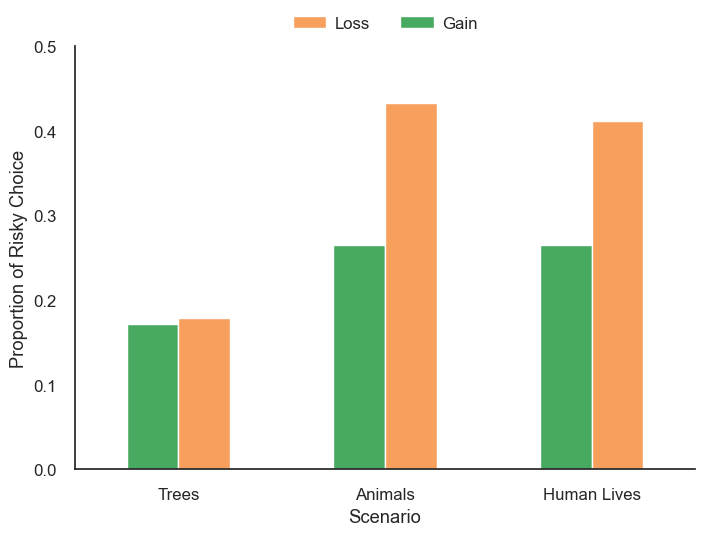

In [77]:
##Graph by Scenario, Risky Choice 
ax = scn_prop_risky.plot(kind="bar", color = [ green, orange])
fig.set_size_inches(.1, .1)
#fig = ax.get_figure()
# change labels
#ax.set_title("Proportion Choosing Risky Option by Scenario")
ax.set_xlabel("Scenario")
ax.set_xticklabels(labels = ['Trees', 'Animals', 'Human Lives' ], rotation = 0)
ax.set_ylabel("Proportion of Risky Choice")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0,0.1,.2,.3,.4, .5])
fig.tight_layout(pad=3)

##plt.legend(bbox_to_anchor=(.2,1.01,.5,1), loc="lower center", ncol=3, frameon=False, handletextpad=0.5, mode='expand')
plt.legend(['Gain',"Loss"],bbox_to_anchor=(.5,1), loc="lower center", ncol=3, frameon=False, handletextpad=0.5, mode='expand')
plt.show()

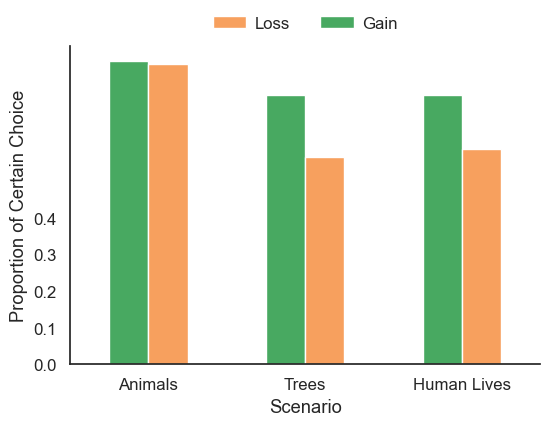

In [50]:
##Graph by Scenario, Certain 

ax = scn_prop_certain.plot(kind="bar", color = [ green, orange])
fig.set_size_inches(.3, .3)
fig = ax.get_figure()
# change labels
#ax.set_title("Proportion Choosing Risky Option by Scenario")
ax.set_xlabel("Scenario")
ax.set_xticklabels(labels = ['Animals', 'Trees', 'Human Lives' ], rotation = 0)
ax.set_ylabel("Proportion of Certain Choice")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0,0.1,.2,.3,.4])
fig.tight_layout(pad=3)

##plt.legend(bbox_to_anchor=(.2,1.01,.5,1), loc="lower center", ncol=3, frameon=False, handletextpad=0.5, mode='expand')
plt.legend(['Gain',"Loss"],bbox_to_anchor=(.5,1), loc="lower center", ncol=3, frameon=False, handletextpad=0.5, mode='expand')
plt.show()

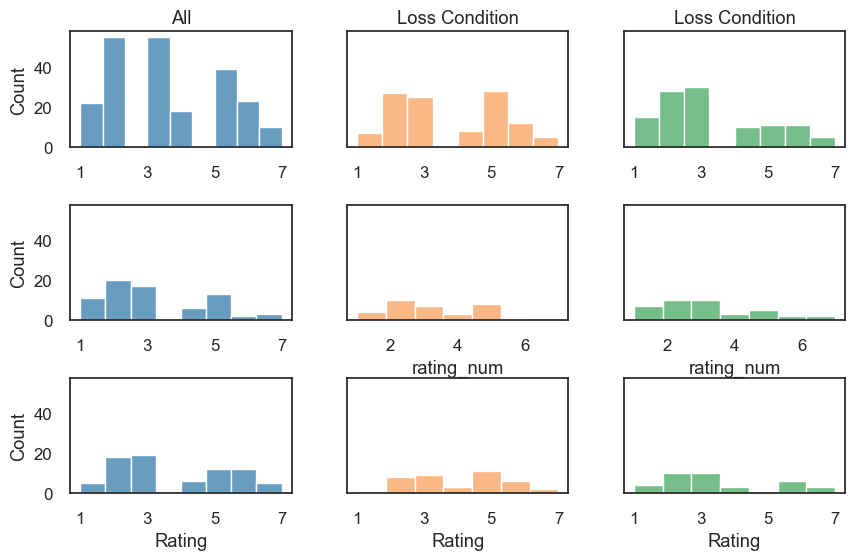

In [109]:
##Histogram of Rating Num Distribution by Condition
loss_for = forest[forest['frame'] == 'loss']
loss_an = animal[animal['frame'] == 'loss']
loss_hum = human[human['frame'] == 'loss']

gain_for = forest[forest['frame'] == 'gain']
gain_an = animal[animal['frame'] == 'gain']
gain_hum = human[human['frame'] == 'gain']


fig, axes = plt.subplots(3, 3, figsize=(10, 6), sharey=True)  # Changed figsize to make the figure taller
plt.subplots_adjust( wspace=.25, hspace=.5)


sns.histplot(data=main_analysis, x='rating_num', ax=axes[0][0], color= blue, edgecolor="w")

axes[0][0].set_title('All')
axes[0][0].set_xlabel('')
axes[0][0].set_xticks([1,3,5,7])

sns.histplot(data=loss_condition, x='rating_num', ax=axes[0][1], color= orange,  edgecolor="w")
axes[0][1].set_title('Loss Condition')
axes[0][1].set_xlabel('')
axes[0][1].set_xticks([1,3,5,7])

sns.histplot(data=gain_condition, x='rating_num', ax=axes[0][2], color= green,  edgecolor="w")
axes[0][2].set_title('Loss Condition')
axes[0][2].set_xlabel('')
axes[0][2].set_xticks([1,3,5,7])

####### Forest
sns.histplot(data=forest, x='rating_num', ax=axes[1][0], color= blue, edgecolor="w")
axes[1][2].set_title('')

axes[1][0].set_xlabel('')
axes[1][0].set_xticks([1,3,5,7])

sns.histplot(data=loss_for, x='rating_num', ax=axes[1][1], color= orange,  edgecolor="w")
axes[0][1].set_xticks([1,3,5,7])

sns.histplot(data=gain_for, x='rating_num', ax=axes[1][2], color= green,  edgecolor="w")
axes[0][2].set_xticks([1,3,5,7])

####### Animal
sns.histplot(data=animal, x='rating_num', ax=axes[2][0], color= blue, edgecolor="w")
axes[2][0].set_xlabel('Rating')
axes[2][0].set_xticks([1,3,5,7])

sns.histplot(data=loss_an, x='rating_num', ax=axes[2][1], color= orange,  edgecolor="w")
axes[2][1].set_xlabel('Rating')
axes[2][1].set_xticks([1,3,5,7])

sns.histplot(data=gain_an, x='rating_num', ax=axes[2][2], color= green,  edgecolor="w")
axes[2][2].set_xlabel('Rating')
axes[2][2].set_xticks([1,3,5,7])

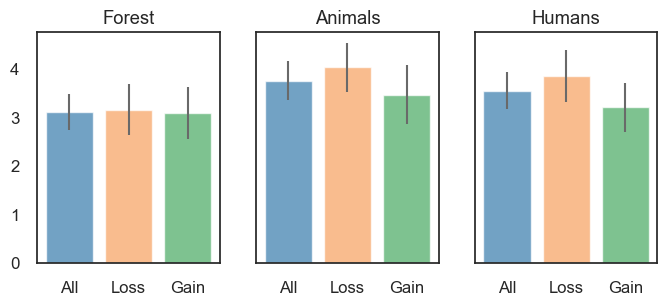

In [134]:
##Plot graph for average rating by condition 
#forest
values_for = np.array([forest.rating_num.mean(), loss_for.rating_num.mean(), gain_for.rating_num.mean(), ])
se_for = np.array([forest.rating_num.std(), loss_for.rating_num.std(), gain_for.rating_num.std()]) / np.sqrt([len(forest), len(loss_for), len(gain_for)])
yerrs_for = 1.96 * se_for
#animal
values_an = np.array([animals.rating_num.mean(), loss_an.rating_num.mean(), gain_an.rating_num.mean(), ])
se_an = np.array([animals.rating_num.std(), loss_an.rating_num.std(), gain_an.rating_num.std()]) / np.sqrt([len(animals), len(loss_an), len(gain_an)])
yerrs_an = 1.96 * se_an

#humans
values_hum = np.array([humans.rating_num.mean(), loss_hum.rating_num.mean(), gain_hum.rating_num.mean(), ])
se_hum = np.array([humans.rating_num.std(), loss_hum.rating_num.std(), gain_hum.rating_num.std()]) / np.sqrt([len(humans), len(loss_hum), len(gain_hum)])
yerrs_hum = 1.96 * se_hum

fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharey=True)  # Changed figsize to make the figure taller

axes[0].bar(np.arange(3), values_for, yerr=yerrs_for, color=[blue, orange, green], alpha=0.7, capsize=3, ecolor='dimgrey')
axes[0].set_title('Forest')
axes[0].set_xticks(np.arange(3), [ 'All', 'Loss', 'Gain', ], rotation='horizontal', fontsize=12)


axes[1].bar(np.arange(3), values_an, yerr=yerrs_an, color=[blue, orange, green], alpha=0.7, capsize=3, ecolor='dimgrey')
axes[1].set_title('Animals')
axes[1].set_xticks(np.arange(3), [ 'All', 'Loss', 'Gain', ], rotation='horizontal', fontsize=12)

axes[2].bar(np.arange(3), values_hum, yerr=yerrs_hum, color=[blue, orange, green], alpha=0.7, capsize=3, ecolor='dimgrey')
axes[2].set_title('Humans')
axes[2].set_xticks(np.arange(3), [ 'All', 'Loss', 'Gain', ], rotation='horizontal', fontsize=12)
plt.show()


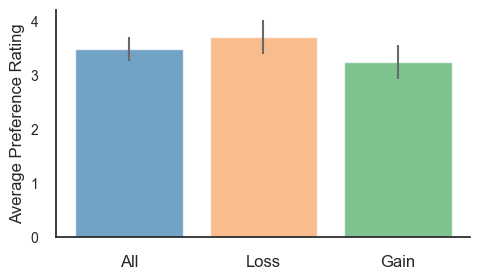

In [117]:
##Plot graph for average rating by condition 
values = np.array([main_analysis.rating_num.mean(), loss_condition.rating_num.mean(), gain_condition.rating_num.mean(), ])
se = np.array([main_analysis.rating_num.std(), loss_condition.rating_num.std(), gain_condition.rating_num.std()]) / np.sqrt([len(main_analysis), len(loss_condition), len(gain_condition)])
yerrs = 1.96 * se
plt.figure(figsize=(5,3))
ax = plt.bar(np.arange(3), values, yerr=yerrs, color=[ blue, orange, green ], alpha=0.7, capsize=1, ecolor='dimgrey')
sns.despine()
plt.ylabel('Average Preference Rating', fontsize=12)
plt.xticks(np.arange(3), [ 'All', 'Loss', 'Gain', ], rotation='horizontal', fontsize=12)
plt.tick_params(axis='y', labelsize=10)
plt.tight_layout()
plt.show()

In [ ]:
##BoxPlot of Rating by Frame
fig = plt.figure(figsize=(5,3))
ax = sns.boxplot(x='frame', y='rating_num', data=main_analysis, color = blue)
plt.title('Risky Choice Framing', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.show()

##### Manipulation / Attention Tests

In [304]:
#look where rationale answer is not null 
rationale_notnull = main_analysis[~main_analysis['rationale'].isna()]
###rationale_cross = pd.crosstab( rationale_notnull['frame'],rationale_notnull['option_selected'], normalize='index')
rationale_cross = pd.crosstab( rationale_notnull['option_selected'],rationale_notnull['frame'], normalize='columns')

print("Breakdown when Rationale answer is not null")
print(f"""Sample Size: {rationale_notnull.shape[0]}""")
print(f"""Gain Sample Size: {rationale_notnull[rationale_notnull['frame'] == 'gain'].shape[0]}""")
print(f"""Loss Sample Size: {rationale_notnull[rationale_notnull['frame'] == 'loss'].shape[0]}""")
rationale_cross

Breakdown when Rationale answer is not null
Sample Size: 162
Gain Sample Size: 85
Loss Sample Size: 77


frame,gain,loss
option_selected,,
Proposal A,0.788235,0.571429
Proposal B,0.211765,0.428571


In [61]:
##look were ADP is not familar
ADP_cross = pd.crosstab(ADP_notyes['frame'], ADP_notyes['option_selected'], normalize='index')
##ADP_cross = pd.crosstab(main_analysis['frame'], main_analysis['option_selected'], normalize='index')

print("Breakdown when ADP answer is not true")
print(f"""Sample Size: {ADP_notyes.shape[0]}""")
print(f"""Gain Sample Size: {ADP_notyes[ADP_notyes['frame'] == 0].shape[0]}""")
print(f"""Loss Sample Size: {ADP_notyes[ADP_notyes['frame'] == 1].shape[0]}""")

Breakdown when ADP answer is not true
Sample Size: 93
Gain Sample Size: 50
Loss Sample Size: 43


In [34]:
#Table of % Choosing Each Option by Frame
rating_appr = main_analysis[((main_analysis['option_selected']=='Proposal A') & (main_analysis['rating_num']<= 4 )) | ((main_analysis['option_selected']=='Proposal B') & (main_analysis['rating_num'] >= 4 ))]
rating_cross = pd.crosstab(rating_appr['option_selected'], rating_appr['frame'])  
print("Breakdown when Rating matches answer")
print(f"""Sample Size: {rating_appr.shape[0]}""")
print(f"""Gain Sample Size: {rating_appr[rating_appr['frame'] == 'gain'].shape[0]}""")
print(f"""Loss Sample Size: {rating_appr[rating_appr['frame'] == 'loss'].shape[0]}""")

rating_cross.round()

Breakdown when Rating matches answer
Sample Size: 202
Gain Sample Size: 103
Loss Sample Size: 99


frame,gain,loss
option_selected,,
Proposal A,79,64
Proposal B,24,35


#### Hypotheses Tests

- H1: Human participants will exhibit the framing effect such that in the gain frame, they will be risk-averse (prefer the certain option) and in the loss frame, they will be risk-seeking (prefer the risky option).
    -  H1.1: Human participants will be more likely to choose the certain option (Proposal A) when the scenario is framed as a gain than when it's framed as a loss.
    - H1.2: The strength of preference, as indicated by 'rating_num', will vary depending on whether the scenario is framed as a gain or loss.
- H2: The type of scenario (trees, humans, or animals) will influence the strength of the framing effect in human participants.

##### Set-up variables 

In [75]:
### Set-up variables 

#set gain as = 1

####Set-up variables


###### Note, main_analysis is where the rating matches the choice selection 

##### For Ordinal 
#####Ordinal Regressions

le = preprocessing.LabelEncoder()

#df_nodup_rap['frame_cat'] = le.fit_transform(df_nodup_rap['frame']) 
#df_nodup_rap['frame_rev'] =  1 - df_nodup_rap['frame_cat']
#df_nodup_rap['scenario_clean_cat'] = le.fit_transform(df_nodup_rap['scenario_clean'])


rating_appr_rat['frame_cat'] = le.fit_transform(rating_appr_rat['frame']) 
rating_appr_rat['frame_rev'] = 1 - rating_appr_rat['frame_cat']

rating_appr_rat['scenario_clean'] = rating_appr_rat['scenario_clean'].astype(pd.CategoricalDtype(categories=['forest', 'animals', 'humans'], ordered=True))
rating_appr_rat['scenario_for'] = rating_appr_rat['scenario_clean'].cat.codes

rating_appr_rat['option_selected_B'] = le.fit_transform(rating_appr_rat['option_selected']) ##0 = Prop A, 1 = Prop B
rating_appr_rat['option_selected_A'] = 1 - rating_appr_rat['option_selected_B']  ## Reversing the encoding

rating_appr_noADP['frame_cat'] = le.fit_transform(rating_appr_noADP['frame']) 
rating_appr_noADP['frame_rev'] = 1 - rating_appr_noADP['frame_cat']
rating_appr_noADP['scenario_clean_cat'] = le.fit_transform(rating_appr_noADP['scenario_clean'])
rating_appr_noADP['option_selected_B'] = le.fit_transform(rating_appr_noADP['option_selected']) ##0 = Prop A, 1 = Prop B
rating_appr_noADP['option_selected_A'] = 1 - rating_appr_noADP['option_selected_B']  ## Reversing the encoding


rating_appr['reversed_rating_num'] = 8 - rating_appr['rating_num']
rating_appr_rat['reversed_rating_num'] = 8 - rating_appr_rat['rating_num']
rating_appr_noADP['reversed_rating_num'] = 8 - rating_appr_noADP['rating_num']


/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_89934/1330095610.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_appr['frame_gain'] = (rating_appr['frame'] == 'gain').astype(int)
/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_89934/1330095610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_appr_rat['frame_gain'] = (rating_appr_rat['frame'] == 'gain').astype(int)
/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T/ipykernel_89934/1330095610.py:7: SettingWithCopyWarni

In [71]:
#function for signficance 
def sig_effect(pvalue):
    if pvalue <= .01:
        return f"""significant at 1% level"""
    elif pvalue <= .05:
        return f"""significant at 5% level"""
    elif pvalue <= .1:
        return f"""significant at 10% level"""
    else:
        return "not significant"


##### Hypothesis Testing (Stat Tests)


- H1.1: Human participants will be more likely to choose the certain option (Proposal A) when the scenario is framed as a gain than when it's framed as a loss.
- H1.2: The strength of preference, as indicated by 'rating_num', will vary depending on whether the scenario is framed as a gain or loss.

In [319]:
###H1: Chi-squared Test (or Fisher's Exact Test) for Option Selected:
contingency_table = pd.crosstab(main_analysis['frame'], main_analysis['option_selected'])
chi2, pval, _, _ = stats.chi2_contingency(contingency_table)

###H2: Kruskal-Wallis Test for Rating ##CHECK ##Reversed Number 
stat, p_val2 = stats.mannwhitneyu(main_analysis[main_analysis['frame']=='gain']['reversed_rating_num'], main_analysis[main_analysis['frame']=='loss']['reversed_rating_num'])

### CHECK THIS 
#ttest for H2?????  
gain = main_analysis['rating_num'][main_analysis['frame'] == 'gain']
loss = main_analysis['rating_num'][main_analysis['frame'] =='loss']

t_stat, p_value = stats.ttest_ind(gain, loss)

###Output as a table
results = {
    ('option selected'): {
        'chi2/stat': chi2,
        'p_val': pval,
        'sig effect': pval < .05
    },
    ('rating number'): {
        'chi2/stat': stat,
        'p_val': p_val2,
        'sig effect': p_val2 < .05
    }}

df_hyp_test = pd.DataFrame.from_dict(results)
df_hyp_test

,option selected,rating number
chi2/stat,2.987508,5749.5
p_val,0.083909,0.109236
sig effect,False,False


In [165]:
##Odds Ratio for Choice Selection
table = sm.stats.Table.from_data(rating_appr[['frame', 'option_selected']])
rslt = table.test_nominal_association()
print(table.local_oddsratios)
#print( rslt.pvalue )


option_selected  Proposal A  Proposal B
frame                                  
gain                1.80013         NaN
loss                    NaN         NaN


In [ ]:
##Effect Size

import math as ma 
# Calculate difference between means and pooled standard deviation
diff = gain_condition['rating_num'].mean() - loss_condition['rating_num'].mean()
pooledstdev = ma.sqrt(((gain_condition['rating_num'].std() ** 2 + loss_condition['rating_num'] ** 2) / 2) )

# Calculate Cohen's d
cohend = diff / pooledstdev
print(cohend)

##### Robustness Check (Linear)

In [228]:
#-- Simple Linear Regression -- #

##Rating Appr
lin_ratingappr = sm.OLS.from_formula('rating_num ~ frame_gain', data = rating_appr).fit()

##Rating Appr Rationale
lin_ratingappr_rat = sm.OLS.from_formula('rating_num ~ frame_gain', data = rating_appr_rat).fit()

#-- Multiple Linear Regression -- #

# Rating Appr with basic demographic controls 
#lin_dem = sm.OLS.from_formula('rating_num ~ frame + scenario_clean + age_num + gender_num + ethnicity_num + education_num', data = main_analysis).fit()

# Rating Appr  Rat with basic demographic controls 
l#in_dem = sm.OLS.from_formula('rating_num ~ frame + scenario_clean + age_num + gender_num + ethnicity_num + education_num', data = main_analysis).fit()

frame coeff: 0.45571428571428413
frame p-vale: 0.05388945375619913

signficicant effect? -->  significant at 10% level


##### Rating Number (Ordinal)

In [ ]:
####### Simple (no controls) Ordinal Regressions #####
##### Version 8/8 #####
##frame_rev: 1 = gain, 0 = loss
##frame_cat: 0 = gain, 1 = loss

##Rating Appr 
ord_logit_ratapp = OrderedModel.from_formula("rating_num ~ 0 + frame_gain ",rating_appr, distr='logit').fit(method='bfgs')
print("\nrating_appr")
print("frame coeff:", ord_logit_ratapp.params[0]) #frame coeff: -0.4026162882171143
print("frame p-vale:", ord_logit_ratapp.pvalues[0]) #frame p-vale: 0.10824411307025375
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp.pvalues[0])) #not significant
print(ord_logit_ratapp.summary())

##rating_appr_rat 
ord_logit_ratapp_rat = OrderedModel.from_formula("rating_num ~ 0 + frame_gain ",rating_appr_rat, distr='logit').fit(method='bfgs')
print("\nrating_appr_rat")
print("frame coeff:", ord_logit_ratapp_rat.params[0]) #frame coeff: -0.6553318352976806
print("frame p-vale:", ord_logit_ratapp_rat.pvalues[0]) #frame p-vale: 0.01854378741043065
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rat.pvalues[0])) ##significant at 5% level
print(ord_logit_ratapp_rat.summary())

############################## --- REVERSING Rating SCALE --- ##############################
##frame_rev or frame_gain: 1 = gain, 0 = loss

##Rating Appr 
ord_logit_ratapp_rev = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_gain ",rating_appr, distr='logit').fit(method='bfgs')
print("\nrating_appr, with reversed rating num")
print("frame coeff:", ord_logit_ratapp_rev.params[0]) #frame coeff:  0.40267782416887127
print("frame p-vale:", ord_logit_ratapp_rev.pvalues[0]) #frame p-vale: 0.1081917719418552
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rev.pvalues[0])) #not significant
print(ord_logit_ratapp_rev.summary())

##rating_appr_rat 
ord_logit_ratapp_rat_rev = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_gain ",rating_appr_rat, distr='logit').fit(method='bfgs')
print("\nrating_appr_rat, with reversed rating num")
print("frame coeff:", ord_logit_ratapp_rat_rev.params[0]) #frame coeff: 0.6553318352976806
print("frame p-vale:", ord_logit_ratapp_rat_rev.pvalues[0]) #frame p-vale: 0.01854378741043065
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rat_rev.pvalues[0])) ##significant at 5% level
print(ord_logit_ratapp_rat_rev.summary())

Optimization terminated successfully.
         Current function value: 1.769040
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20

rating_appr
frame coeff: -0.4026162882171143
frame p-vale: 0.10824411307025375

signficicant effect? -->  not significant
                             OrderedModel Results                             
Dep. Variable:             rating_num   Log-Likelihood:                -357.35
Model:                   OrderedModel   AIC:                             728.7
Method:            Maximum Likelihood   BIC:                             751.8
Date:                Sat, 12 Aug 2023                                         
Time:                        13:53:33                                         
No. Observations:                 202                                         
Df Residuals:                     195                                         
Df Model:                           1                                    

In [ ]:
###table for Simple Comparison 
summary_stats_ord_v1 = [get_summary_stats(ord_logit_ratapp_rev), 
                 get_summary_stats(ord_logit_ratapp_rat_rev)]
summary_ord_df1 = pd.DataFrame(summary_stats_ord_v1)
summary_ord_df1.T

table1 = summary_ord_df1.T
print(tabulate(table1, tablefmt = 'pretty', headers=["variable", "All Participants", "Rationale Only"]))

+-----------------+------------------+----------------+
|    variable     | All Participants | Rationale Only |
+-----------------+------------------+----------------+
| frame gain coef |      0.4027      |     0.6554     |
|     std_err     |      0.251       |     0.278      |
|     p value     |      0.1082      |    0.0185**    |
|  conf_interval  |  -0.089 - 0.894  |  0.11 - 1.201  |
|   Odds Ratio    |      1.4958      |     1.926      |
|        n        |       202        |      167       |
+-----------------+------------------+----------------+


In [ ]:
##Rating Appr + scenario Test 1 ----- ARCHIVE
##- frame rev

ord_logit_ratapp_scn_rev = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_gain + scenario_for ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_scn_rev.params[0]) #frame coeff: 0.39692462854097943
print("frame p-vale:", ord_logit_ratapp_scn_rev.pvalues[0]) #frame p-vale: 0.11372859896970955
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_scn_rev.pvalues[0])) #not significant
print(ord_logit_ratapp_scn_rev.summary())


##animal as reference group

ord_logit_ratapp_scn_rev1 = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_gain + scenario_an ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_scn_rev1.params[0]) #frame coeff: 0.39692462854097943
print("frame p-vale:", ord_logit_ratapp_scn_rev1.pvalues[0]) #frame p-vale: 0.0.11219090241577075
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_scn_rev1.pvalues[0])) #not significant
print(ord_logit_ratapp_scn_rev1.summary())


ord_logit_ratapp_scn_rev4 = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_gain + scenario_hum ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_scn_rev4.params[0]) #frame coeff: 0.39692462854097943
print("frame p-vale:", ord_logit_ratapp_scn_rev4.pvalues[0]) #frame p-vale: 0.11372859896970955
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_scn_rev4.pvalues[0])) #not significant
print(ord_logit_ratapp_scn_rev4.summary())

#scenario_an	0.3348	0.157	2.136	0.033	0.028	0.642
#scenario_for	-0.0839	0.150	-0.560	0.576	-0.378	0.210

Optimization terminated successfully.
         Current function value: 1.768264
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
frame coeff: 0.39693873763644294
frame p-vale: 0.11371587101014753

signficicant effect? -->  not significant
                              OrderedModel Results                             
Dep. Variable:     reversed_rating_num   Log-Likelihood:                -357.19
Model:                    OrderedModel   AIC:                             730.4
Method:             Maximum Likelihood   BIC:                             756.8
Date:                 Fri, 11 Aug 2023                                         
Time:                         16:19:33                                         
No. Observations:                  202                                         
Df Residuals:                      194                                         
Df Model:                            2                                        

In [ ]:
####### Ordinal Regression Models W/ Scenario #####
##### Version 8/8 #####

#Rating Appr 
ord_logit_ratapp_scn= OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(scenario_clean)",rating_appr, distr='logit').fit(method='bfgs')
ord_logit_ratapp_scn.summary()
print("frame coeff:", ord_logit_ratapp_scn.params[2]) #frame coeff: -0.37223733181945245
print("frame p-vale:", ord_logit_ratapp_scn.pvalues[2]) #frame p-vale: 0.13932979613932026
print("scn_animals coeff:", ord_logit_ratapp_scn.params[0]) # coeff: 0.8543537217311111
print("scn_animals p-vale:", ord_logit_ratapp_scn.pvalues[0]) # p-vale: 0.006354326800319145
print("scn_humans coeff:", ord_logit_ratapp_scn.params[1]) # coeff: .6950380028024601
print("scn_humans p-vale:", ord_logit_ratapp_scn.pvalues[1]) # p-vale: 0.0274679915333521
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_scn.pvalues[2])) #not significant
print(ord_logit_ratapp_scn.summary())

#Rating Appr Rat
ord_logit_ratapp_rat_scn= OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(scenario_clean)",rating_appr_rat, distr='logit').fit(method='bfgs')
ord_logit_ratapp_rat_scn.summary()
print("frame coeff:", ord_logit_ratapp_rat_scn.params[2]) #frame coeff: -0.594515184123428
print("frame p-vale:", ord_logit_ratapp_rat_scn.pvalues[2]) #frame p-vale: 0.033675152520790765
print("scn_animals coeff:", ord_logit_ratapp_rat_scn.params[0]) # coeff: 0.9262575959774988
print("scn_animals p-vale:", ord_logit_ratapp_rat_scn.pvalues[0]) # p-vale: 0.0069183948800673484
print("scn_humans coeff:", ord_logit_ratapp_rat_scn.params[1]) # coeff: 0.6372244770565717
print("scn_humans p-vale:", ord_logit_ratapp_rat_scn.pvalues[1]) # p-vale: 0.05785075484928358
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rat_scn.pvalues[2])) # significant at 5% level
print(ord_logit_ratapp_rat_scn.summary())

Optimization terminated successfully.
         Current function value: 1.748433
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
frame coeff: 0.3722461647604964
frame p-vale: 0.13931884884958698
scn_animals coeff: -0.854322269579967
scn_animals p-vale: 0.0063560418951903895
scn_humans coeff: -0.6950755063843667
scn_humans p-vale: 0.027459090091790404

signficicant effect? -->  not significant
                              OrderedModel Results                             
Dep. Variable:     reversed_rating_num   Log-Likelihood:                -353.18
Model:                    OrderedModel   AIC:                             724.4
Method:             Maximum Likelihood   BIC:                             754.1
Date:                 Sat, 12 Aug 2023                                         
Time:                         14:05:47                                         
No. Observations:                  202                                         
D

In [ ]:
###table for Scenario Comparison 
summary_stats_ordscn = [get_summary_stats(ord_logit_ratapp_scn), 
                 get_summary_stats(ord_logit_ratapp_rat_scn)]
summary_stats_ordscn_df1 = pd.DataFrame(summary_stats_ordscn)
summary_stats_ordscn_df1.T

table1 = summary_stats_ordscn_df1.T
print(tabulate(table1, tablefmt = 'pretty', headers=["variable", "All Participants", "Rationale Only"]))

+-----------------+------------------+----------------+
|    variable     | All Participants | Rationale Only |
+-----------------+------------------+----------------+
| frame gain coef |      0.3722      |     0.5945     |
|     std_err     |      0.252       |      0.28      |
|     p value     |      0.1393      |    0.0337**    |
|  conf_interval  |  -0.121 - 0.866  | 0.046 - 1.143  |
|   Odds Ratio    |      1.451       |     1.812      |
|        n        |       202        |      167       |
+-----------------+------------------+----------------+


In [ ]:
####### Demographic Model Regressions #####
##### Version 8/8 #####

##Rating Appr + basic dem controls 
##- frame rev
ord_logit_dem = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education)",rating_appr, distr='logit').fit(method='bfgs')
ord_logit_dem.summary()

##Rating Appr Rat + basic dem controls 
##- frame rev
ord_logit_dem1 = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education)",rating_appr_rat, distr='logit').fit(method='bfgs')
ord_logit_dem1.summary()

##Rating Appr + all dem controls 
##- frame frame_gain
ord_logit_demall = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education) + C(continent_grouped) + C(student)",rating_appr, distr='logit').fit(method='bfgs')
ord_logit_demall.summary()

##Rating Appr Rat + all dem controls 
##- frame frame_gain
ord_logit_demall1 = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education) + C(continent_grouped) + C(student)",rating_appr_rat, distr='logit').fit(method='bfgs')
ord_logit_demall1.summary()

##Rating Appr + all controls 
##- frame frame_gain
ord_logit_conall = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education) + C(continent_grouped) + C(student) + C(ADP_No)",rating_appr, distr='logit').fit(method='bfgs')
ord_logit_conall.summary()

##Rating Appr Rat + all controls 
##- frame frame_gain
ord_logit_conall1 = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education) + C(continent_grouped) + C(student) + C(ADP_No)",rating_appr_rat, distr='logit').fit(method='bfgs')
ord_logit_conall1.summary()



Optimization terminated successfully.
         Current function value: 1.740547
         Iterations: 95
         Function evaluations: 97
         Gradient evaluations: 97
Optimization terminated successfully.
         Current function value: 1.751121
         Iterations: 97
         Function evaluations: 98
         Gradient evaluations: 98
Optimization terminated successfully.
         Current function value: 1.733132
         Iterations: 105
         Function evaluations: 106
         Gradient evaluations: 106
Optimization terminated successfully.
         Current function value: 1.741948
         Iterations: 109
         Function evaluations: 110
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: 1.733433
         Iterations: 112
         Function evaluations: 113
         Gradient evaluations: 113
Optimization terminated successfully.
         Current function value: 1.739211
         Iterations: 112
         Function evaluati

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                             
===============================================================================
Dep. Variable:     reversed_rating_num   Log-Likelihood:                -285.23
Model:                    OrderedModel   AIC:                             618.5
Method:             Maximum Likelihood   BIC:                             692.9
Date:                 Sat, 12 Aug 2023                                         
Time:                         14:11:19                                         
No. Observations:                  164                                         
Df Residuals:                      140                                         
Df Model:                           18                                         
====================================================================================================================================================
                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------
C(age)[T.25 - 34 years old]                                                          0.5908      0.393      1.504      0.133      -0.179       1.361
C(age)[T.35 - 44 years old]                                                          1.0655      0.530      2.009      0.045       0.026       2.105
C(age)[T.45+]                                                                       -0.2305      0.748     -0.308      0.758      -1.697       1.236
C(gender)[T.Male]                                                                   -0.5038      0.312     -1.615      0.106      -1.115       0.108
C(gender)[T.Other]                                                                  -0.3128      0.908     -0.344      0.730      -2.092       1.467
C(ethnicity)[T.Black/African/Caribbean]                                              0.1399      0.680      0.206      0.837      -1.193       1.473
C(ethnicity)[T.Other]                                                               -0.0871      1.980     -0.044      0.965      -3.968       3.794
C(ethnicity)[T.Prefer not to say]                                                   -0.9314      1.568     -0.594      0.552      -4.004       2.141
C(ethnicity)[T.White or Caucasian]                                                   0.1729      0.502      0.344      0.731      -0.811       1.157
C(education)[T.Bachelor's degree]                                                   -0.6434      0.447     -1.441      0.150      -1.519       0.232
C(education)[T.Completed high school / secondary school]                             0.2356      0.559      0.421      0.674      -0.861       1.332
C(education)[T.Graduate or professional degree (MA, MS, MBA, PHd, JD, MD, etc.)]    -1.4167      0.526     -2.692      0.007      -2.448      -0.385
C(continent_grouped)[T.Europe]                                                       0.5284      0.406      1.303      0.193      -0.266       1.323
C(continent_grouped)[T.Asia]                                                         0.0852      0.571      0.149      0.881      -1.035       1.205
C(continent_grouped)[T.Other / Not Provided]                                        -0.4652      0.599     -0.777      0.437      -1.639       0.708
C(student)[T.Yes]                                                                   -0.0478      0.358     -0.134      0.894      -0.749       0.654
C(ADP_No)[T.No]                                                                      0.0309      0.324      0.095      0.924      -0.604       0.666
frame_gain                                                                           0.7423      0.305      2.433      0.015       0.144       1.340
1.0/2.0                

In [ ]:
##Tables for models with controls

###table for Control Comparison 
summary_ordit_con_v1 = [get_summary_stats(ord_logit_ratapp), 
                 get_summary_stats(ord_logit_dem),
                 get_summary_stats(ord_logit_demall ),
                 get_summary_stats(ord_logit_conall)]

summary_ordit_con_df1 = pd.DataFrame(summary_ordit_con_v1)
summary_ordit_con_df1.T

summary_ordit_con_v2 = [get_summary_stats(ord_logit_ratapp_rat), 
                 get_summary_stats(ord_logit_dem1),
                 get_summary_stats(ord_logit_demall1 ),
                 get_summary_stats(ord_logit_conall1)]
summary_ordit_con_df2 = pd.DataFrame(summary_ordit_con_v2)
summary_ordit_con_df2.T

controls_ordit_tab1 = summary_ordit_con_df1.T
controls_ordit_tab2 = summary_ordit_con_df2.T

print("Rating Appr")
print(tabulate(controls_ordit_tab1, headers = ('No Controls', 'Basic Demographic','All Demographics', 'All Controls' ), tablefmt = 'pretty'))

print("Rating Appr Rat")
print(tabulate(controls_ordit_tab2, headers = ('No Controls - Rat', 'Basic Demographic','All Demographics', 'All Controls' ), tablefmt = 'pretty'))

Rating Appr
+-----------------+----------------+-------------------+------------------+----------------+
|                 |  No Controls   | Basic Demographic | All Demographics |  All Controls  |
+-----------------+----------------+-------------------+------------------+----------------+
| frame gain coef |    -0.4026     |      0.4401       |      0.4059      |     0.4155     |
|     std_err     |     0.251      |       0.259       |      0.262       |     0.264      |
|     p value     |     0.1082     |      0.0891*      |      0.1211      |     0.1154     |
|  conf_interval  | -0.894 - 0.089 |  -0.067 - 0.948   |  -0.107 - 0.919  | -0.102 - 0.933 |
|   Odds Ratio    |     0.6686     |      1.5529       |      1.5007      |     1.5151     |
|        n        |      202       |        202        |       202        |      199       |
+-----------------+----------------+-------------------+------------------+----------------+
Rating Appr Rat
+-----------------+-------------------+---

In [ ]:
####Ordinial W/ Additional Variables 
##frame_rev: 1 = gain, 0 = loss
##data = 8/8

##Main Analysis + scenario + dem controls 
##- frame rev
###ord_logit_ma_con = OrderedModel.from_formula("rating_num ~ 0 + frame_cat + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",main_analysis, distr='logit').fit(method='bfgs')

##opt2 
ord_logit_ma_con2 = OrderedModel.from_formula("rating_num ~ 0 + frame_cat + scenario_clean + age + gender + ethnicity + education",main_analysis, distr='logit').fit(method='bfgs')

print("frame coeff:", ord_logit_ma_con.params[0]) #frame coeff: 0.5490264706653798
print("frame p-vale:", ord_logit_ma_con.pvalues[0]) #frame p-vale: 0.025202916533813863
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ma_con.pvalues[0])) #significant at 5% level
##ord_logit_ma_con.summary()


##############


##Rating Appr + scenario + dem controls 
##- frame rev
ord_logit_ratapp_con = OrderedModel.from_formula("rating_num ~ 0 + frame_cat + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_con.params[0]) #frame coeff: 0.44349340890944816
print("frame p-vale:", ord_logit_ratapp_con.pvalues[0]) #frame p-vale: 0.08508049975937666
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_con.pvalues[0])) #significant at 10% level
##ord_logit_ratapp_con.summary()


##Rating Appr + scenario + dem controls + ADP
##- frame rev
ord_logit_ratapp_conadp = OrderedModel.from_formula("rating_num ~ 0 + frame_cat + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num + ADP_num ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_conadp.params[0]) #frame coeff: 0.4262986778780437
print("frame p-vale:", ord_logit_ratapp_conadp.pvalues[0]) #frame p-vale: 0.10023696086693651
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_conadp.pvalues[0])) #not significant
##ord_logit_ratapp_conadp.summary()

In [ ]:
######## #Reversed Scales

##Rating Appr with controls 
ord_logit_ratapp_rev_con = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_rev + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",rating_appr, distr='logit').fit(method='bfgs')
print("\nrating_appr, with reversed rating num")
print("frame coeff:", ord_logit_ratapp_rev_con.params[0]) #frame coeff: 0.44351924048966374
print("frame p-vale:", ord_logit_ratapp_rev_con.pvalues[0]) #frame p-vale: 0.08506239407465632
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rev_con.pvalues[0])) #significant at 10% level
print(ord_logit_ratapp_rev_con.summary())

##Rating Appr with noADP
ord_logit_ratappADP_rev_con = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_rev + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",rating_appr_noADP, distr='logit').fit(method='bfgs')
print("\nrating_appr_noADP, with reversed rating num")
print("frame coeff:", ord_logit_ratappADP_rev_con.params[0]) #frame coeff: 0.9228055025259196
print("frame p-vale:", ord_logit_ratappADP_rev_con.pvalues[0]) #frame p-vale: 0.016354339402560036
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratappADP_rev_con.pvalues[0])) #significant at 5% level
print(ord_logit_ratappADP_rev_con.summary())

Optimization terminated successfully.
         Current function value: 1.752930
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33

rating_appr, with reversed rating num
frame coeff: 0.44351924048966374
frame p-vale: 0.08506239407465632

signficicant effect? -->  significant at 10% level
                              OrderedModel Results                             
Dep. Variable:     reversed_rating_num   Log-Likelihood:                -341.82
Model:                    OrderedModel   AIC:                             707.6
Method:             Maximum Likelihood   BIC:                             746.9
Date:                 Tue, 08 Aug 2023                                         
Time:                         18:24:29                                         
No. Observations:                  195                                         
Df Residuals:                      183                                         
Df Model:                     

##### Logistic Regression

In [98]:
########## Simple Model ##########

########## 8/8 Version  ##########
##rating_appr
logit_ratingappr = smf.logit('option_selected_A ~ frame_gain', rating_appr).fit()
print("frame coeff:", logit_ratingappr.params[1]) #frame coeff: 0.5878590002488179
print("frame p-vale:", logit_ratingappr.pvalues[1]) #frame p-vale: 0.06108608807922693
print(f"Odds Ratio: {np.exp(logit_ratingappr.params[1])}") #1.8001302083333337
print("\nsignficicant effect? --> ", sig_effect(logit_ratingappr.pvalues[1])) #significant at 10% level
print(logit_ratingappr.summary())  #observations: 202 

##rating_appr_rat 
logit_reg_rating_rat = smf.logit('option_selected_A ~ frame_gain', rating_appr_rat).fit()
print("frame coeff:", logit_reg_rating_rat.params[1]) #frame coeff: 1.0325221768391197
print("frame p-vale:", logit_reg_rating_rat.pvalues[1]) #frame p-vale: 0.0024665370461273723
print("\nsignficicant effect? --> ", sig_effect(logit_reg_rating_rat.pvalues[1])) ##significant at 1% level
print(logit_reg_rating_rat.summary())  #observations: 167

#Rating_appr - Gain condition only 
logit_ratingappr_gain = smf.logit('option_selected_A ~ 1', gain_condition_rating).fit()
print(logit_ratingappr_gain.summary()) 

#Rating_appr rat - Gain condition only 
logit_ratingappr_rat_gain = smf.logit('option_selected_A ~ 1', gain_condition_rating_rat).fit()
print(logit_ratingappr_rat_gain.summary()) 

#Rating_appr - Loss condition only 
logit_ratingappr_loss = smf.logit('option_selected_B ~ 1', loss_condition_rating).fit()
print(logit_ratingappr_loss.summary()) 

#Rating_appr rat - Loss condition only 
logit_ratingappr_rat_loss = smf.logit('option_selected_B ~ 1', loss_condition_rating_rat).fit()
print(logit_ratingappr_rat_loss.summary()) 


##"Intercept: 0.6286": This is the log-odds of choosing Proposal A when frame_gain is 0 (i.e., when the scenario is framed as a loss). The coefficient is significantly different from zero at the 1% level (p=0.004).
#frame_gain: 0.6035": This is the change in the log-odds of choosing Proposal A for a one-unit change in frame_gain. Since frame_gain is a binary variable (0 or 1), this change is the difference in log-odds between a gain and a loss frame. A positive coefficient suggests that when the scenario is framed as a gain, the log-odds of choosing Proposal A increase.

Optimization terminated successfully.
         Current function value: 0.595191
         Iterations 5
frame coeff: 0.5878590002488179
frame p-vale: 0.06108608807922693
Odds Ratio: 1.8001302083333337

signficicant effect? -->  significant at 10% level
                           Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                  202
Model:                          Logit   Df Residuals:                      200
Method:                           MLE   Df Model:                            1
Date:                Tue, 15 Aug 2023   Pseudo R-squ.:                 0.01459
Time:                        16:32:13   Log-Likelihood:                -120.23
converged:                       True   LL-Null:                       -122.01
Covariance Type:            nonrobust   LLR p-value:                   0.05919
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

In [ ]:
##for power analysis 
predicted_probs = logit_ratingappr_gain.predict(gain_condition_rating)
odds = round(np.exp(logit_ratingappr_gain.params['Intercept']),4)# Average of these predicted probabilities will give Pr(Y=1|X=1)
prob_Y1_given_X1 = np.mean(predicted_probs)
prob_Y1_given_X1
pi_value = len(gain_condition_rating) / len(rating_appr)
pi_value
print(odds)

##caveat that too low for gain version

predicted_probs2 = logit_ratingappr.predict(rating_appr)
odds2 = round(np.exp(logit_ratingappr.params['frame_gain']),4)# Average of these predicted probabilities will give Pr(Y=1|X=1)
prob_Y1_given_X1_2 = np.mean(predicted_probs2)
print(prob_Y1_given_X1_2)
#pi_value = len(gain_condition_rating) / len(rating_appr)
print(odds2)

3.2917
0.7079207920792079
1.8001


In [139]:
#Create tables for Simple 
from tabulate import tabulate

## function for 'frame_gain' regressions 
def get_summary_stats(model):
    p_val = model.pvalues['frame_gain']
    conf_interval = f"{round(model.conf_int().loc['frame_gain', 0], 3)} - {round(model.conf_int().loc['frame_gain', 1], 3)}"
    if p_val < 0.01:
        asterisks = '***'
    elif p_val < 0.05:
        asterisks = '**'
    elif p_val < 0.10:
        asterisks = '*'
    else:
        asterisks = ''
    return {
        'Frame (Gain)': f"{round(model.params['frame_gain'],3)} ({round(model.bse['frame_gain'],3)})",
        'Constant': f"{round(model.params['Intercept'],3)} ({round(model.bse['Intercept'],3)})",
        'P-value': f"{round(p_val,3)}{asterisks}",
        'Confidence Interval': conf_interval, 
        'Odds Ratio': round(np.exp(model.params['frame_gain']),3),
        'Observations ':model.nobs,
        'Pseudo R^2': round(model.prsquared,3)

    }

## function for 'intercept' regressions 
def intercept_summary(model):
    p_val = model.pvalues['Intercept']
    conf_interval = f"{round(model.conf_int().loc['Intercept', 0], 3)} - {round(model.conf_int().loc['Intercept', 1], 3)}"
    if p_val < 0.01:
        asterisks = '***'
    elif p_val < 0.05:
        asterisks = '**'
    elif p_val < 0.10:
        asterisks = '*'
    else:
        asterisks = ''
    return {
        'Constant': f"{round(model.params['Intercept'],3)} ({round(model.bse['Intercept'],3)})",
        'std_err' : round(model.bse['Intercept'],3),
        'p value': f"{round(p_val,3)}{asterisks}",
        'conf_interval': conf_interval, 
        'Odds Ratio': round(np.exp(model.params['Intercept']),3),
        'n': round(model.nobs,3),
        'Pseudo R^2': round(model.prsquared,3)

    }

###table for Simple Comparison 
summary_stats_logit_v1 = [get_summary_stats(logit_ratingappr),
                          get_summary_stats(logit_reg_rating_rat)]
summary_logit_df1 = pd.DataFrame(summary_stats_logit_v1)
summary_logit_df1.T

table1 = summary_logit_df1.T
basic_models = summary_logit_df1.T
print(basic_models)
basic_models.to_csv('basic_models_table.csv', index=False)

##table for gain / loss Comparison 
summary_options = [intercept_summary(logit_ratingappr_gain), 
                 intercept_summary(logit_ratingappr_rat_gain),
                 intercept_summary(logit_ratingappr_loss),
                 intercept_summary(logit_ratingappr_rat_loss)                 
                 ]
summary_options_df = pd.DataFrame(summary_options)

options_tables = summary_options_df.T
##print('\n')
##print(tabulate(options_tables, tablefmt = 'pretty', headers=["variable", "Gain Condition - All", "Gain Condition - Rationale Only","Loss Condition - All", "Loss Condition - Rationale Only" ]))
options_tables.to_csv('options_tables.csv')

                                  0              1
Frame (Gain)          0.588 (0.314)  1.033 (0.341)
Constant               0.604 (0.21)  0.206 (0.228)
P-value                      0.061*       0.002***
Confidence Interval  -0.027 - 1.203  0.364 - 1.701
Odds Ratio                      1.8          2.808
Observations                    202            167
Pseudo R^2                    0.015          0.045


In [ ]:
##########  ADP Versions ##########

########## 8/8 ##########
#ating Appr
logit_ADPNo_ratingappr = smf.logit('option_selected_A ~ frame_rev + C(ADP_No)', rating_appr).fit()
print("frame coeff:", logit_ADPNo_ratingappr.params[2])  #frame coeff: frame coeff: 0.6305057083048329
print("frame p-vale:", logit_ADPNo_ratingappr.pvalues[2]) #frame p-vale:  0.04767859296463091
print("ADP coeff:", logit_ADPNo_ratingappr.params[1])  # coeff: frame coeff: -0.11247583550477258
print("ADP p-vale:", logit_ADPNo_ratingappr.pvalues[1]) # p-vale:  0.7229922428617646
print("\nsignficicant effect? --> ", sig_effect(logit_ADPNo_ratingappr.pvalues[2])) #significant at 5% level
print(logit_ADPNo_ratingappr.summary())
#coefficient is -0.1124, suggesting that being familiar with ADP -> to a decrease in the log odds of selecting Proposal A

#Rating Appr Rat
logit_ADPNo_ratingappr_rat = smf.logit('option_selected_A ~ frame_rev + C(ADP_No)', rating_appr_rat).fit()
print("frame coeff:", logit_ADPNo_ratingappr_rat.params[2])  #frame coeff: frame coeff: 1.0818773551539747
print("frame p-vale:", logit_ADPNo_ratingappr_rat.pvalues[2]) #frame p-vale:  0.0018309528592363926
print("ADP coeff:", logit_ADPNo_ratingappr_rat.params[1])  # coeff: frame coeff: 0.12954604771423606
print("ADP p-vale:", logit_ADPNo_ratingappr_rat.pvalues[1]) # p-vale:  0.7076142556285303
print("\nsignficicant effect? --> ", sig_effect(logit_ADPNo_ratingappr_rat.pvalues[2]))  #significant at 1% level
print(logit_ADPNo_ratingappr_rat.summary())
#coefficient is -0.1124, suggesting that being familiar with ADP -> to a decrease in the log odds of selecting Proposal A

##Rating Appr Rat with ADP excluded
logit_reg_noADP = smf.logit('option_selected_A ~ frame_gain', rating_appr_noADP).fit()  ##1 = Prop A, 0 = Prop B
print("\Simple Model with No ADP Familarity")
print("frame coeff:", logit_reg_noADP.params[1]) #1.156309277988964
print("frame p-vale:", logit_reg_noADP.pvalues[1]) #0.010706997573492305
print("\nsignficicant effect? --> ", sig_effect(logit_reg_noADP.pvalues[1])) #significant at 5% level
#print(logit_reg_noADP.summary())

##Rating Appr Rat with ADP excluded
logit_reg_noADP2 = smf.logit('option_selected_A ~ frame_gain', rating_appr_rat_noADP).fit()  ##1 = Prop A, 0 = Prop B
print("\Simple Model with No ADP Familarity")
print("frame coeff:", logit_reg_noADP2.params[1]) #1.381521082367233
print("frame p-vale:", logit_reg_noADP2.pvalues[1]) #0.003437058838870402
print("\nsignficicant effect? --> ", sig_effect(logit_reg_noADP2.pvalues[1])) #significant at 1% level
#print(logit_reg_noADP2.summary())

Optimization terminated successfully.
         Current function value: 0.592949
         Iterations 5
frame coeff: 0.6457377036839086
frame p-vale: 0.043285479626060386
ADP coeff: -0.11247583550477258
ADP p-vale: 0.7229922428617646

signficicant effect? -->  significant at 5% level
                           Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                  199
Model:                          Logit   Df Residuals:                      196
Method:                           MLE   Df Model:                            2
Date:                Fri, 11 Aug 2023   Pseudo R-squ.:                 0.01740
Time:                        22:30:35   Log-Likelihood:                -118.00
converged:                       True   LL-Null:                       -120.09
Covariance Type:            nonrobust   LLR p-value:                    0.1237
                      coef    std err          z      P>|z|      [0.025      0.975]
-

In [ ]:
#Create tables for ADP 
from tabulate import tabulate


###table for ADP Comparison 
summary_stats_ADP_v1 = [get_summary_stats(logit_reg_ratingappr, 'logit_rating'), 
                 get_summary_stats(logit_ADPNo_ratingappr, 'ADP_control_rating'),
                 get_summary_stats(logit_reg_noADP, 'ADP_notyes_rating')]
summary_ADP_df1 = pd.DataFrame(summary_stats_ADP_v1)
summary_ADP_df1.T


summary_stats_ADP_v2 = [get_summary_stats(logit_reg_rating_rat, 'logit_rationale'), 
                 get_summary_stats(logit_ADPNo_ratingappr_rat, 'ADP_control_rationale'),
                 get_summary_stats(logit_reg_noADP2, 'ADP_notyes_rationale')]
summary_ADP_df2 = pd.DataFrame(summary_stats_ADP_v2)
summary_ADP_df2.T

tab1 = summary_ADP_df2.T
print(tabulate(tab1, tablefmt = 'pretty'))

,0,1,2
model,logit_rationale,ADP_control_rationale,ADP_notyes_rationale
coef,1.0325,0.1295,1.3815
std_err,0.3411,0.3454,0.4722
p_value,0.0025,0.7076,0.0034
conf_int_low,0.3641,-0.5474,0.456
conf_int_high,1.701,0.8065,2.307
odds_ratio,2.8081,1.1383,3.981
n,167,164,94
significant_effect,Yes,No,Yes


In [87]:
##########  Scenario Versions ##########

########## 8/8 ##########
#ating Appr
logit_rating_scn = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean)', rating_appr).fit()
print("frame coeff:", logit_rating_scn.params[3])  #frame coeff: frame coeff: 0.557044115663797
print("frame p-vale:", logit_rating_scn.pvalues[3]) #frame p-vale:  0.0802787775635036
print("animals coeff:", logit_rating_scn.params[1])  # coeff: frame coeff: -0.9142439974316887
print("animals p-vale:", logit_rating_scn.pvalues[1]) # p-vale:  0.7229922428617646
print("humans coeff:", logit_rating_scn.params[2])  # coeff: frame coeff: -0.8636220964915821
print("humans p-vale:", logit_rating_scn.pvalues[2]) # p-vale:  0.04079430506839161
print("\nsignficicant effect? --> ", sig_effect(logit_rating_scn.pvalues[3])) #significant at 10% level
print(logit_rating_scn.summary())

#Rating Appr Rat
logit_rating_scn2 = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean)', rating_appr_rat).fit()
print("frame coeff:", logit_rating_scn2.params[3])  #frame coeff: frame coeff: 0.557044115663797
print("frame p-vale:", logit_rating_scn2.pvalues[3]) #frame p-vale: 0.005048574805227938
print("animals coeff:", logit_rating_scn2.params[1])  # coeff: frame coeff: -1.1119886805286159
print("animals p-vale:", logit_rating_scn2.pvalues[1]) # p-vale: 0.012419198230763746
print("humans coeff:", logit_rating_scn2.params[2])  # coeff: frame coeff:-0.8993008344054968
print("humans p-vale:", logit_rating_scn2.pvalues[2]) # p-vale: 0.04273187465875459
print("\nsignficicant effect? --> ", sig_effect(logit_rating_scn2.pvalues[3])) #significant at 1% level
print(logit_rating_scn2.summary())


Optimization terminated successfully.
         Current function value: 0.580189
         Iterations 5
frame coeff: 0.557044115663797
frame p-vale: 0.0802787775635036
animals coeff: -0.9142439974316887
animals p-vale: 0.028531850275997285
humans coeff: -0.8636220964915821
humans p-vale: 0.040794305068391615

signficicant effect? -->  significant at 10% level
                           Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                  202
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            3
Date:                Tue, 15 Aug 2023   Pseudo R-squ.:                 0.03943
Time:                        16:28:27   Log-Likelihood:                -117.20
converged:                       True   LL-Null:                       -122.01
Covariance Type:            nonrobust   LLR p-value:                   0.02208
        

In [100]:
### With Controls Models #####

##Rating Appr with Scenario + basic demographic controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 
logit_reg_dem = smf.logit('option_selected_A ~ frame_gain + C(age) + C(gender)+ C(ethnicity) + C(education)', rating_appr).fit()
print("frame coeff:", logit_reg_dem.params[13])  #frame coeff:   0.7271781809222718
print("frame p-vale:", logit_reg_dem.pvalues[13]) #frame p-vale: 0.037323068115545005
print("\nsignficicant effect?", sig_effect(logit_reg_dem.pvalues[13])) #significant at 5% level
print("\n\n\n",logit_reg_dem.summary())
 
##Rating Appr with Scenario + basic demographic controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 
logit_reg_demb = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity) + C(education)', rating_appr).fit()
print("frame coeff:", logit_reg_demb.params[15])  #frame coeff:   0.7271781809222718
print("frame p-vale:", logit_reg_demb.pvalues[15]) #frame p-vale: 0.037323068115545005
print("\nsignficicant effect?", sig_effect(logit_reg_demb.pvalues[15])) #significant at 5% level
print("\n\n\n",logit_reg_demb.summary())


##Rating Appr with Scenario + all demographic controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 
logit_reg_demall = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity)+ C(education) +  C(continent_grouped) + C(student)', rating_appr).fit()
print("frame coeff:", logit_reg_demall.params[19]) # frame coeff: 0.6773080280922608
print("frame p-vale:", logit_reg_demall.pvalues[19]) #frame p-vale:  0.06050466791136513
print("\nsignficicant effect?", sig_effect(logit_reg_demall.pvalues[19])) #significant at 10% level
logit_reg_demall.summary()

##Rating Appr with all demographic controls + scenario + ADP
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 
logit_reg_conall = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity)+ C(education) +  C(continent_grouped) + C(student) + C(ADP_No)', rating_appr).fit()
print("frame coeff:", logit_reg_conall.params[20]) # frame coeff: .7453067314741395
print("frame p-vale:", logit_reg_conall.pvalues[20]) # frame p-vale: 0.04417210042673677
print("\nsignficicant effect?", sig_effect(logit_reg_conall.pvalues[20])) #significant at 5% level
logit_reg_conall.summary()


################ Rating Appr Rationale ################
##Rating Appr Rationale with Scenario + basic demographic controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 

logit_reg_demb2 = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity) + C(education)', rating_appr_rat).fit()
print("frame coeff:", logit_reg_demb2.params[15])  #frame coeff:  0.7394700819157529
print("frame p-vale:", logit_reg_demb2.pvalues[15]) #frame p-vale: 0.03591022737590693
print("\nsignficicant effect?", sig_effect(logit_reg_demb2.pvalues[15])) #significant at 5% level
print("\n\n\n",logit_reg_demb2.summary())

##Rating Appr Rationale with Scenario + all demographic controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 
logit_reg_demall2 = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity)+ C(education) +  C(continent_grouped) + C(student)', rating_appr_rat).fit()
logit_reg_demall2.summary()

##Rating Appr Rationale with all demographic controls + scenario + ADP
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 

logit_reg_conall2 = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity)+ C(education) +  C(continent_grouped) + C(student) + C(ADP_No)', rating_appr_rat).fit()
print("frame coeff:", logit_reg_conall2.params[20]) # frame coeff: 0.7336901911721359
print("frame p-vale:", logit_reg_conall2.pvalues[20]) # frame p-vale: 0.04867989536640349
print("\nsignficicant effect?", sig_effect(logit_reg_conall2.pvalues[20])) #significant at 5% level
logit_reg_conall2.summary()




Optimization terminated successfully.
         Current function value: 0.563190
         Iterations 6
frame coeff: 0.7159166033802988
frame p-vale: 0.0363053110045323

signficicant effect? significant at 5% level



                            Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                  202
Model:                          Logit   Df Residuals:                      188
Method:                           MLE   Df Model:                           13
Date:                Tue, 15 Aug 2023   Pseudo R-squ.:                 0.06757
Time:                        16:33:49   Log-Likelihood:                -113.76
converged:                       True   LL-Null:                       -122.01
Covariance Type:            nonrobust   LLR p-value:                    0.2238
                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
--

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      option_selected_A   No. Observations:                  164
Model:                          Logit   Df Residuals:                      143
Method:                           MLE   Df Model:                           20
Date:                Tue, 15 Aug 2023   Pseudo R-squ.:                  0.1926
Time:                        16:33:50   Log-Likelihood:                -83.909
converged:                       True   LL-Null:                       -103.92
Covariance Type:            nonrobust   LLR p-value:                  0.004962
====================================================================================================================================================
                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                            1.0324      1.089      0.948      0.343      -1.102       3.167
C(scenario_clean)[T.animals]                                                        -1.4417      0.520     -2.773      0.006      -2.461      -0.423
C(scenario_clean)[T.humans]                                                         -0.7979      0.513     -1.557      0.120      -1.803       0.207
C(age)[T.25 - 34 years old]                                                          0.5905      0.576      1.025      0.305      -0.539       1.720
C(age)[T.35 - 44 years old]                                                          1.4641      0.787      1.861      0.063      -0.077       3.006
C(age)[T.45+]                                                                       -0.4882      1.023     -0.477      0.633      -2.493       1.516
C(gender)[T.Male]                                                                   -0.2255      0.422     -0.534      0.593      -1.053       0.602
C(gender)[T.Other]                                                                  -0.0269      1.248     -0.022      0.983      -2.474       2.420
C(ethnicity)[T.Black/African/Caribbean]                                             -1.3078      0.911     -1.436      0.151      -3.093       0.477
C(ethnicity)[T.Other]                                                               -1.7877      1.934     -0.924      0.355      -5.578       2.003
C(ethnicity)[T.Prefer not to say]                                                   -0.2310      1.739     -0.133      0.894      -3.639       3.177
C(ethnicity)[T.White or Caucasian]                                                  -0.0898      0.653     -0.138      0.891      -1.369       1.189
C(education)[T.Bachelor's degree]                                                   -0.5596      0.608     -0.920      0.358      -1.752       0.633
C(education)[T.Completed high school / secondary school]                             0.3669      0.851      0.431      0.666      -1.302       2.036
C(education)[T.Graduate or professional degree (MA, MS, MBA, PHd, JD, MD, etc.)]    -1.2882      0.720     -1.789      0.074      -2.700       0.123
C(continent_grouped)[T.Europe]                                                       1.5087      0.589      2.560      0.010       0.354       2.664
C(continent_grouped)[T.Asia]                                                         0.1007      0.765      0.132      0.895      -1.398       1.600
C(continent_grouped)[T.Other / Not Provided]                                         0.2127      0.735      0.289      0.772      -1.228       1.654
C(student)[T.Yes]                                                                    0.1511      0.502      0.30

In [120]:
##Tables for main paper -- models with controls

###table for Control Comparison 
summary_stats_con_v1 = [get_summary_stats(logit_ratingappr), 
               ## get_summary_stats(logit_rating_scn),
                get_summary_stats(logit_reg_dem),
                 get_summary_stats(logit_reg_demb),
               ##  get_summary_stats(logit_reg_demall ),
                 get_summary_stats(logit_reg_conall)]

summary_con_df1 = pd.DataFrame(summary_stats_con_v1)
summary_con_df1.T


summary_stats_con_v2 = [get_summary_stats(logit_reg_rating_rat), 
                 get_summary_stats(logit_reg_demb2),
                 get_summary_stats(logit_reg_demall2 ),
                 get_summary_stats(logit_reg_conall2)]
summary_con_df2 = pd.DataFrame(summary_stats_con_v2)
summary_con_df2.T

controls_tab1 = summary_con_df1.T
controls_tab2 = summary_con_df2.T

print("Rating Appr")
controls_tab1.to_csv('ratingappr_controlscomparison.csv')
#print(tabulate(controls_tab1, headers = ('No Controls','+ Basic Dem', '+ SCN & Basic Demographic', '+ All Controls' ), tablefmt = 'pretty'))

Rating Appr


[]

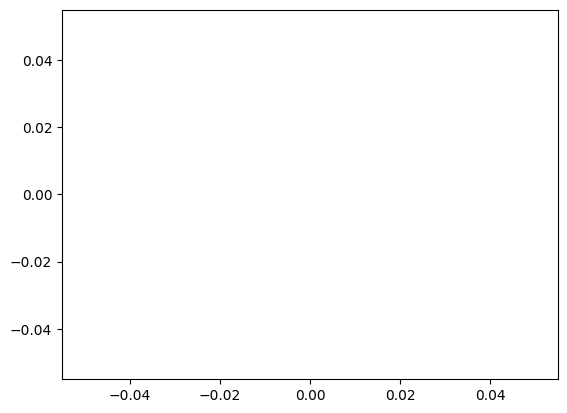

In [203]:
##Plotting Residuals

import matplotlib.pyplot as plt
%matplotlib inline

# Deviance residuals
deviance_residuals = logit_ratingappr.resid_dev

# Plot
plt.plot()

